# 3. Data Modeling 
#### 2020_10_27

In [1]:
# data preprocessing
import pandas as pd
import numpy as np
# data visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud

# sklearn 
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score
from sklearn.metrics import f1_score, confusion_matrix, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
# from CatBoost import CatBoostClassifier

import re
import ast # 형변환 

from pprint import pprint as pp
import warnings
warnings.filterwarnings(action='ignore')

# 텍스트 마이닝
# from eunjeon import Mecab
# import nltk
# from konlpy.tag import Okt
# from nltk import FreqDist
# from gensim.models import Word2Vec

In [2]:
# font
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False   

##  1. 데이터 불러오기

In [15]:
# EDA 완료한 데이터 불러오기 
df_raw = pd.read_csv('EDA_03')
pet = df_raw.copy()
print(pet.shape)
print(pet.info())

(324702, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324702 entries, 0 to 324701
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   desertionno             324702 non-null  int64  
 1   popfile                 324702 non-null  object 
 2   happendt                324702 non-null  object 
 3   happenplace             324702 non-null  object 
 4   knm                     297107 non-null  object 
 5   colorcd                 324656 non-null  object 
 6   age                     324600 non-null  float64
 7   weight                  324569 non-null  object 
 8   noticeno                324701 non-null  object 
 9   noticesdt               324702 non-null  object 
 10  noticeedt               324702 non-null  object 
 11  sexcd                   324702 non-null  int64  
 12  neuteryn                324702 non-null  int64  
 13  specialmark             324702 non-null  object 
 14  carenm 

In [16]:
col_list = [ 'age', 'sexcd', 'neuteryn', 'type', 'lat', 'long',
            'blc_col', 'brown_col', 'white_col', 'grey_col', 'yellow_col',
            'kindcd', 'weight_float', 
            'noticesdt_year','noticesdt_month', 'noticesdt_day', 
            'good_behavior', 'sensitive','disease', 'accident', 'processstate_adopt', 'processstate_euthanize']
pet = pet[col_list]

## 2. 결손값 처리하기 np.nan

In [17]:
pet.isnull().sum()

age                          102
sexcd                          0
neuteryn                       0
type                           0
lat                            0
long                           0
blc_col                        0
brown_col                      0
white_col                      0
grey_col                       0
yellow_col                     0
kindcd                      1035
weight_float                 426
noticesdt_year                 0
noticesdt_month                0
noticesdt_day                  0
good_behavior             248092
sensitive                 294667
disease                   290835
accident                  279028
processstate_adopt             0
processstate_euthanize         0
dtype: int64

In [19]:
pet.good_behavior = pet.good_behavior.fillna(0)
pet.sensitive = pet.sensitive.fillna(0)
pet.disease = pet.disease.fillna(0)
pet.accident = pet.accident.fillna(0)

In [20]:
# 몸무게 이상치 처리 : 논리적으로 판단 
# 1) 강아지 견종별 표준 몸무게 참고 : 최대 ~ 82kg  : https://parkminsuk.tistory.com/101 
# 2) 고양이 표준 몸무게 :  3.6 – 4.5 kg (Adult) : 최대 5.8kg : https://m.blog.naver.com/PostView.nhn?blogId=graindea&logNo=220363109747&proxyReferer=https:%2F%2Fwww.google.com%2F

print(pet[(pet.type == 1.0) & (pet.weight_float > 82)]['weight_float'].count()) # 55
print(pet[(pet.type == 0.0) & (pet.weight_float > 10)]['weight_float'].count()) # 137

55
137


In [21]:
# 일단 결측치로 입력
pet[(pet.type == 1.0) & (pet.weight_float > 82)]['weight_float'] = np.nan # 55
pet[(pet.type == 0.0) & (pet.weight_float > 10)]['weight_float'] = np.nan # 278

In [22]:
# 결측치 처리하기 

p = SimpleImputer(missing_values=np.nan, strategy='mean')
df_filter = pet.filter(['age','weight_float'])

res = p.fit_transform(df_filter.values)
res

array([[ 5. ,  8. ],
       [ 2. ,  7. ],
       [ 1. , 10. ],
       ...,
       [ 1. ,  0.2],
       [ 1. ,  0.5],
       [ 2. ,  3. ]])

In [23]:
df_mean = pd.DataFrame(res, index = df_filter.index, columns= ['age', 'weight'])
df_mean

,age,weight
0,5.0,8.0
1,2.0,7.0
2,1.0,10.0
3,2.0,15.0
4,4.0,14.0
...,...,...
324697,1.0,0.3
324698,1.0,1.5
324699,1.0,0.2
324700,1.0,0.5


In [24]:
pet = pet.drop(columns= ['age', 'weight_float'], axis=1)

In [25]:
pet = pd.merge(pet, df_mean, left_index=True, right_index=True)
pet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324702 entries, 0 to 324701
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   sexcd                   324702 non-null  int64  
 1   neuteryn                324702 non-null  int64  
 2   type                    324702 non-null  int64  
 3   lat                     324702 non-null  float64
 4   long                    324702 non-null  float64
 5   blc_col                 324702 non-null  int64  
 6   brown_col               324702 non-null  int64  
 7   white_col               324702 non-null  int64  
 8   grey_col                324702 non-null  int64  
 9   yellow_col              324702 non-null  int64  
 10  kindcd                  323667 non-null  float64
 11  noticesdt_year          324702 non-null  int64  
 12  noticesdt_month         324702 non-null  int64  
 13  noticesdt_day           324702 non-null  int64  
 14  good_behavior       

In [26]:
# kindcd 결측치 0으로 채우기
pet.kindcd = pet.kindcd.fillna(0)

In [27]:
# 인코딩/정규화 하기 전 데이터 셋 1
df_pet = pet.copy()

## 3. encoding 

In [28]:
# 원핫인코딩 - kindcd 품종정보 
df_oh = pd.get_dummies(pet, columns=['kindcd'], prefix='jong')
df_oh

,sexcd,neuteryn,type,lat,long,blc_col,brown_col,white_col,grey_col,yellow_col,...,jong_203.0,jong_205.0,jong_206.0,jong_207.0,jong_208.0,jong_209.0,jong_210.0,jong_211.0,jong_212.0,jong_214.0
0,1,2,1,35.228545,128.889352,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,34.486871,126.263485,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,34.486871,126.263485,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,34.486871,126.263485,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,34.311060,126.755054,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324697,0,0,0,36.446535,127.119153,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
324698,0,0,0,37.536950,126.737744,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
324699,0,0,0,37.536950,126.737744,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
324700,1,0,0,37.506982,126.721774,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# # 원핫인코딩 - kindcd 품종정보 

# oh_encoder = OneHotEncoder()
# x = oh_encoder.fit_transform(pet['kindcd'].values.reshape(-1, 1)).toarray()

In [17]:
# ohdf2 = pd.DataFrame(x, columns=['kind'+str(int(i)) for i in range(x.shape[1])])
# df_oh = pd.concat([pet, ohdf2], axis=1)
# df_oh

In [30]:
df_oh.isnull().sum().sum()

0

## 4. scaling : Standardscaler 정규화  

In [31]:
scaler = StandardScaler()
scaler.fit(df_oh)
pet_oh_scaled = scaler.transform(df_oh)

In [20]:
df_final = pd.DataFrame(data=pet_oh_scaled, columns=df_oh.columns)
df_final

,sexcd,neuteryn,type,lat,long,blc_col,brown_col,white_col,grey_col,yellow_col,...,jong_203.0,jong_205.0,jong_206.0,jong_207.0,jong_208.0,jong_209.0,jong_210.0,jong_211.0,jong_212.0,jong_214.0
0,0.326745,1.450005,0.726059,-0.904907,0.159430,1.500274,-0.787074,0.865666,-0.218758,-0.357855,...,-0.00555,-0.025379,-0.001755,-0.002482,-0.001755,-0.002482,-0.001755,-0.001755,-0.32626,-0.009771
1,0.326745,-0.723486,0.726059,-1.544251,-0.045586,-0.666545,-0.787074,-1.155180,-0.218758,2.794427,...,-0.00555,-0.025379,-0.001755,-0.002482,-0.001755,-0.002482,-0.001755,-0.001755,-0.32626,-0.009771
2,-0.824632,-0.723486,0.726059,-1.544251,-0.045586,-0.666545,-0.787074,0.865666,-0.218758,-0.357855,...,-0.00555,-0.025379,-0.001755,-0.002482,-0.001755,-0.002482,-0.001755,-0.001755,-0.32626,-0.009771
3,0.326745,-0.723486,0.726059,-1.544251,-0.045586,-0.666545,-0.787074,-1.155180,-0.218758,2.794427,...,-0.00555,-0.025379,-0.001755,-0.002482,-0.001755,-0.002482,-0.001755,-0.001755,-0.32626,-0.009771
4,0.326745,-0.723486,0.726059,-1.695806,-0.007206,-0.666545,-0.787074,0.865666,-0.218758,-0.357855,...,-0.00555,-0.025379,-0.001755,-0.002482,-0.001755,-0.002482,-0.001755,-0.001755,-0.32626,-0.009771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324697,-0.824632,-0.723486,-1.377299,0.145034,0.021221,-0.666545,-0.787074,-1.155180,-0.218758,2.794427,...,-0.00555,-0.025379,-0.001755,-0.002482,-0.001755,-0.002482,-0.001755,-0.001755,-0.32626,-0.009771
324698,-0.824632,-0.723486,-1.377299,1.085004,-0.008558,1.500274,-0.787074,0.865666,-0.218758,-0.357855,...,-0.00555,-0.025379,-0.001755,-0.002482,-0.001755,-0.002482,-0.001755,-0.001755,-0.32626,-0.009771
324699,-0.824632,-0.723486,-1.377299,1.085004,-0.008558,1.500274,-0.787074,0.865666,4.571260,-0.357855,...,-0.00555,-0.025379,-0.001755,-0.002482,-0.001755,-0.002482,-0.001755,-0.001755,-0.32626,-0.009771
324700,0.326745,-0.723486,-1.377299,1.059170,-0.009805,-0.666545,-0.787074,0.865666,4.571260,-0.357855,...,-0.00555,-0.025379,-0.001755,-0.002482,-0.001755,-0.002482,-0.001755,-0.001755,-0.32626,-0.009771


In [21]:
# 정규화가 잘 되었는지 확인
print('features 평균 값: ', df_final.mean()) # 각 피쳐별로 나옴 
print('features 분산 값: ', df_final.var())

features 평균 값:  sexcd         1.064109e-13
neuteryn      2.368014e-14
type         -2.005273e-12
lat           5.461354e-15
long         -1.150209e-15
                  ...     
jong_209.0   -3.862855e-15
jong_210.0    3.342143e-15
jong_211.0    4.371165e-15
jong_212.0   -1.049260e-12
jong_214.0   -1.368862e-14
Length: 209, dtype: float64
features 분산 값:  sexcd         1.000003
neuteryn      1.000003
type          1.000003
lat           1.000003
long          1.000003
                ...   
jong_209.0    1.000003
jong_210.0    1.000003
jong_211.0    1.000003
jong_212.0    1.000003
jong_214.0    1.000003
Length: 209, dtype: float64


In [22]:
# label 값을 0,1로 바꾸기 

In [23]:
df_final.processstate_adopt.value_counts()

-0.643637    229590
 1.553670     95112
Name: processstate_adopt, dtype: int64

In [24]:
df_final.processstate_euthanize.value_counts()

-0.505905    258533
 1.976654     66169
Name: processstate_euthanize, dtype: int64

In [25]:
df_final.processstate_adopt = df_final.processstate_adopt.apply(lambda x : '1' if x > 0 else '0')

In [26]:
df_final.processstate_euthanize = df_final.processstate_euthanize.apply(lambda x : '1' if x > 0 else '0')

In [27]:
# 인코딩/정규화 하기 전 데이터 셋 2
df_pet2 = df_final.copy()

In [28]:
# 데이터 프레임 2개로 테스트 
df_pet.shape, df_pet2.shape

((324702, 22), (324702, 209))

In [29]:
df_pet.to_csv('./df_pet', index=False)

In [30]:
df_pet2.to_csv('./df_pet2', index=False)

## 5. test/train set 나누기 

In [ ]:
# 데이터 셋의 점수 차이가 크지 않아서 인코딩/정규화 한 데이터셋으로 진행 

In [31]:
df_pet2 = pd.read_csv('./df_pet2')

In [32]:
# 피쳐, 라벨 데이터 나누기 
label_adopt = df_pet2.processstate_adopt
label_euthanize = df_pet2.processstate_euthanize

In [33]:
features = df_pet2.drop(columns = ['processstate_adopt', 'processstate_euthanize'], axis=1,inplace=False)

In [34]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324702 entries, 0 to 324701
Columns: 207 entries, sexcd to jong_214.0
dtypes: float64(207)
memory usage: 512.8 MB


In [51]:
#  train/test split 나누기 - Stratified 로 
X_train, X_test, y_train, y_test = train_test_split(features, label_adopt, test_size=0.2, stratify=label_adopt, random_state=42)


In [52]:
#  validation split from train split 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 6. train set 시각적 탐색

##### 입양 여부에 따라 어떤 시기에 입양이 잘 됐나?

In [65]:
final_df = df_pet.drop(['lat','long'], axis=1)

final_df_0 = final_df[final_df.processstate_adopt == 0]
final_df_1 = final_df[final_df.processstate_adopt == 1]

In [66]:
gr_df = final_df_1[['noticesdt_month','sexcd']]
k1 = gr_df.groupby('noticesdt_month')
t1 = k1.count().reset_index()
t1

gr_df = final_df_0[['noticesdt_month','sexcd']]
k2 = gr_df.groupby('noticesdt_month')
t2 = k2.count().reset_index()
t2

,noticesdt_month,sexcd
0,1,15317
1,2,14242
2,3,16733
3,4,16410
4,5,17042
5,6,20485
6,7,26274
7,8,22445
8,9,25146
9,10,24806


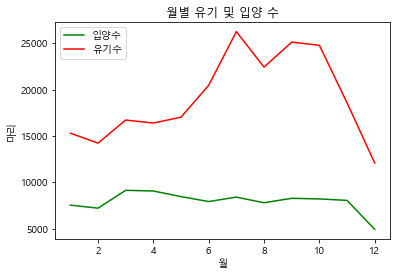

In [71]:
axx = plt.plot(t1.noticesdt_month, t1.sexcd, color='green')	# HTML color name
axx = plt.plot(t2.noticesdt_month, t2.sexcd, color='red')	# HTML color name

plt.title('월별 유기 및 입양 수') 
plt.xlabel('월') 
plt.ylabel('마리')
plt.legend(labels = ['입양수', '유기수'])
# plt.to_file('./')

##### 인사이트
###### 월별 입양율의 편차는 없는 반면, 7 ~ 10월에 유기수가 높아짐
###### 휴가철이기 때문으로 판단


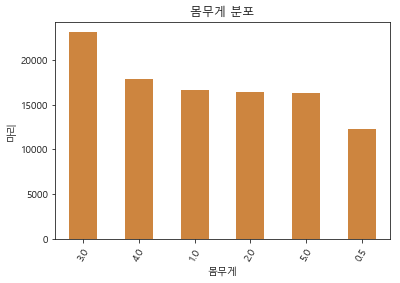

In [78]:
# 몸무게
weight_name = [3.0, 4.0, 1.0, 2.0, 5.0, 0.5]
ax_weight = df_pet.weight.value_counts().iloc[:6].plot(kind = 'bar', color = 'peru')
ax_weight.set_xticklabels(weight_name, rotation=60)
ax_weight.set_title('몸무게 분포')
ax_weight.set_xlabel('몸무게')
ax_weight.set_ylabel('마리')
plt.show()




Text(0.5,0,'성별')

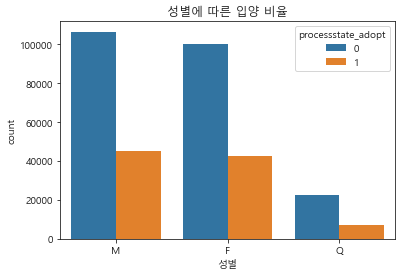

In [80]:
# 성별에 따른 입양 비율
sex_name = ['M', 'F', 'Q']
ax = sns.countplot(x = 'sexcd', hue = 'processstate_adopt', data = df_pet )
ax.set_xticklabels(sex_name)
ax.set_title('성별에 따른 입양 비율')
ax.set_xlabel('성별')


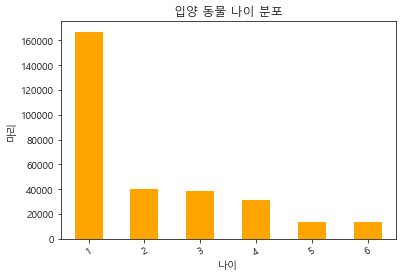

In [82]:
# 입양동물 나이 분포
age_x = ['1', '2', '3', '4', '5', '6']
ax_age = df_pet.age.value_counts().iloc[:6].plot(kind = 'bar', color = 'orange')

ax_age.set_xticklabels(age_x, rotation=30)
ax_age.set_title('입양 동물 나이 분포')
ax_age.set_xlabel('나이')
ax_age.set_ylabel('마리')
plt.show()



## 7. 모델 선정
###### 교차 검증으로 분류 모델 점수 비교 및 선정 

In [37]:
# Decision Tree Classifier 
dt_clf = DecisionTreeClassifier(random_state=156)

#Logistic Regression - 개별 모델
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=156)

#K-최근접 이웃 분류기 모델 - 개별 모델
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=8)

# RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=156)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
from sklearn.ensemble import VotingClassifier 
vo_clf = VotingClassifier( estimators = [('LR', lr_clf), ('KNN',knn_clf)], voting='soft')

# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=156)

# XGBOOST
import xgboost as xgb
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=156)

# LIGHT GBM 
from lightgbm import LGBMClassifier
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# GaussianNB
from sklearn.naive_bayes import GaussianNB
clf_pf = GaussianNB()

# SVC
from sklearn.svm import SVC
clf_svc = SVC(random_state=156)

# category boosting
# cat_bo = CatBoostClassifier(random_state=156)

In [38]:
model_list = [lgbm_wrapper, dt_clf, lr_clf, rf_clf, gb_clf, xgb_model, clf_pf, clf_svc, vo_clf, knn_clf]

In [ ]:

for model in model_list:
    print(f'{model}_____________________________')
    result = cross_validate(model, features, label_adopt, 
               scoring={'정확도': 'accuracy',
                        'ROC-AUC':'roc_auc',
                        'f1': 'f1',
                        '정밀도':'precision',
                        '재현율(민감도)':'recall', 
                        'neg_brier_score':'neg_brier_score',
                        'neg_log_loss':'neg_log_loss',
                        'jaccard':'jaccard',
#                         'confusion' : 'confusion_matrix'
                       }, 
               return_train_score=False, 
               cv=5)
    print(result)

DecisionTreeClassifier(random_state=156)_____________________________
{'fit_time': array([3.84761691, 3.52163315, 3.73301649, 3.50562453, 3.50929022]), 'score_time': array([0.14561009, 0.14256692, 0.15458608, 0.1505971 , 0.15256405]), 'test_정확도': array([0.59587934, 0.59395451, 0.50551278, 0.59123807, 0.54536495]), 'test_ROC-AUC': array([0.48750051, 0.47663261, 0.5155708 , 0.54575913, 0.54704139]), 'test_f1': array([0.24759174, 0.21769959, 0.38952892, 0.38374927, 0.41332168]), 'test_정밀도': array([0.27230876, 0.2498638 , 0.30509232, 0.34361618, 0.33224714]), 'test_재현율(민감도)': array([0.22698838, 0.19287179, 0.5385869 , 0.4344969 , 0.54673536]), 'test_neg_brier_score': array([-0.40392241, -0.40591471, -0.49361397, -0.40818211, -0.45310631]), 'test_neg_log_loss': array([-13.93197805, -14.01185291, -17.00637403, -14.05651937,
       -15.57722113]), 'test_jaccard': array([0.14128657, 0.12214528, 0.24187265, 0.23743177, 0.26049494])}
LogisticRegression(random_state=156)__________________________

In [40]:
# lgbm_wrapper + adopt

cross_validate(lgbm_wrapper, features, label_adopt, 
               scoring={'정확도': 'accuracy',
                        'ROC-AUC':'roc_auc',
                        'f1': 'f1',
                        '정밀도':'precision',
                        '재현율(민감도)':'recall', 
#                         'neg_brier_score':'neg_brier_score',
                        'neg_log_loss':'neg_log_loss',
#                         'jaccard':'jaccard',
#                         'confusion' : 'confusion_matrix'
                       }, 
               return_train_score=False, 
               cv=3)


{'fit_time': array([9.26270819, 9.2454648 , 9.21261644]),
 'score_time': array([1.32305408, 1.35766912, 1.71341681]),
 'test_정확도': array([0.63262006, 0.55621154, 0.62715043]),
 'test_ROC-AUC': array([0.59200771, 0.54655895, 0.70301285]),
 'test_f1': array([0.38053249, 0.38879204, 0.51818952]),
 'test_정밀도': array([0.37595813, 0.32585372, 0.416902  ]),
 'test_재현율(민감도)': array([0.38521953, 0.48186349, 0.68448776]),
 'test_neg_log_loss': array([-0.77943933, -0.89925183, -0.63354741])}

In [108]:
# from CatBoost import CatBoostClassifier
# Catboostclassifier 점수내기 

cross_validate(cat_bo, features, label_adopt, 
               scoring={'정확도': 'accuracy',
                        'ROC-AUC':'roc_auc',
                        'f1': 'f1',
                        '정밀도':'precision',
                        '재현율(민감도)':'recall', 
#                         'neg_brier_score':'neg_brier_score',
                        'neg_log_loss':'neg_log_loss',
#                         'jaccard':'jaccard',
#                         'confusion' : 'confusion_matrix'
                       }, 
               return_train_score=False, 
               cv=10)

Learning rate set to 0.116359
0:	learn: 0.6661129	total: 73ms	remaining: 1m 12s
1:	learn: 0.6444802	total: 94.2ms	remaining: 47s
2:	learn: 0.6273696	total: 116ms	remaining: 38.4s
3:	learn: 0.6141706	total: 136ms	remaining: 33.8s
4:	learn: 0.6037753	total: 155ms	remaining: 30.8s
5:	learn: 0.5950391	total: 181ms	remaining: 30.1s
6:	learn: 0.5892649	total: 199ms	remaining: 28.3s
7:	learn: 0.5834398	total: 222ms	remaining: 27.5s
8:	learn: 0.5786433	total: 256ms	remaining: 28.2s
9:	learn: 0.5744666	total: 301ms	remaining: 29.8s
10:	learn: 0.5711565	total: 333ms	remaining: 30s
11:	learn: 0.5681347	total: 355ms	remaining: 29.2s
12:	learn: 0.5653532	total: 373ms	remaining: 28.3s
13:	learn: 0.5628062	total: 395ms	remaining: 27.8s
14:	learn: 0.5604936	total: 416ms	remaining: 27.3s
15:	learn: 0.5589698	total: 459ms	remaining: 28.2s
16:	learn: 0.5570238	total: 483ms	remaining: 27.9s
17:	learn: 0.5544701	total: 506ms	remaining: 27.6s
18:	learn: 0.5530896	total: 536ms	remaining: 27.7s
19:	learn: 0.5

{'fit_time': array([29.77516246, 28.04621434, 28.82121921, 30.56055164, 30.63035655,
        30.68966603, 28.11786342, 26.45543957, 24.15530491, 30.75216293]),
 'score_time': array([0.10870624, 0.08681774, 0.04991627, 0.05689955, 0.05485225,
        0.05290914, 0.04983616, 0.05392003, 0.09274769, 0.05170846]),
 'test_정확도': array([0.70810877, 0.44421176, 0.43430859, 0.38955959, 0.38441638,
        0.56901755, 0.56144133, 0.55943948, 0.5960579 , 0.69568833]),
 'test_ROC-AUC': array([0.76855011, 0.35962344, 0.47572046, 0.28703287, 0.3318827 ,
        0.5481514 , 0.5847507 , 0.52042764, 0.59795403, 0.73548871]),
 'test_f1': array([0.00753927, 0.22428541, 0.14208314, 0.09637566, 0.16354202,
        0.35422243, 0.386894  , 0.2491996 , 0.30040538, 0.54547127]),
 'test_정밀도': array([0.94736842, 0.18970406, 0.12782587, 0.08507727, 0.13583594,
        0.31565096, 0.32759752, 0.2487948 , 0.30486089, 0.48487079]),
 'test_재현율(민감도)': array([0.00378469, 0.27428511, 0.15992009, 0.11113448, 0.20544633,


In [ ]:
#최종 점수 비교 

In [41]:
LGBMClassifier_result = {'fit_time': ([10.17200637,  9.4461    ,  9.33937812,  9.44675612,  9.22282577]),
 'score_time': ([0.70611119, 0.68616557, 0.67237639, 0.69515228, 0.67320013]),
 'test_정확도': ([0.76603853, 0.76584155, 0.76397444, 0.76491762, 0.76597629]),
 'test_ROC-AUC': ([0.79184431, 0.79233852, 0.79057673, 0.7876541 , 0.79167294]),
 'test_f1': ([0.49457358, 0.49587667, 0.49284473, 0.49101896, 0.49324775]),
 'test_정밀도': ([0.67342317, 0.67126669, 0.66495536, 0.67118605, 0.67430199]),
 'test_재현율(민감도)': ([0.39078723, 0.39315285, 0.39151005, 0.38710737, 0.38884143]),
 'test_neg_brier_score': ([-0.16002624, -0.16019638, -0.16069881, -0.16117585, -0.16033621]),
 'test_neg_log_loss': ([-0.48681337, -0.48688473, -0.48867188, -0.4902294 , -0.48746971]),
 'test_jaccard': ([0.32852723, 0.3296782 , 0.32700329, 0.3253977 , 0.32735823])}

DecisionTreeClassifier_result = {'fit_time': ([4.02026987, 3.71726608, 3.79908514, 3.70016623, 3.76344824]),
  'score_time': ([0.15951395, 0.15452695, 0.16456747, 0.16256928, 0.16357017]),
  'test_정확도': ([0.59554057, 0.59355415, 0.50582076, 0.59017555, 0.54538035]), 
  'test_ROC-AUC': ([0.48703175, 0.47717041, 0.51624564, 0.54517425, 0.54870819]), 
  'test_f1': ([0.24587999, 0.21975228, 0.39018736, 0.38399222, 0.41581416]), 
  'test_정밀도': ([0.27089264, 0.25104687, 0.3055291 , 0.34302374, 0.3333968 ]),
  'test_재현율(민감도)': ([0.22509594, 0.19539505, 0.53974345, 0.43607402, 0.55236042]),
  'test_neg_brier_score': ([-0.40418183, -0.40626151, -0.49337508, -0.40929703, -0.45305136]),
  'test_neg_log_loss': ([-13.94344481, -14.02308476, -17.00033797, -14.09242677, -15.57362297]), 
  'test_jaccard': ([0.14017284, 0.12343916, 0.2423806 , 0.23761781, 0.26247814])}

LogisticRegression_result = {'fit_time': ([2.42261505, 2.36415195, 2.58508563, 2.28887844, 5.27289844]),
  'score_time': ([0.14765978, 0.14871049, 0.15169978, 0.14760494, 0.1505971 ]),
  'test_정확도': ([0.71059885, 0.71358618, 0.68979058, 0.71088697, 0.7197567 ]), 
  'test_ROC-AUC': ([0.66066603, 0.6442938 , 0.65647586, 0.6402152 , 0.67901843]), 
  'test_f1': ([0.10085159, 0.17640808, 0.35281267, 0.2941464 , 0.18040982]), 
  'test_정밀도': ([0.56093667, 0.55939343, 0.45361421, 0.51629933, 0.62928055]), 
  'test_재현율(민감도)': ([0.05540661, 0.10471534, 0.28866576, 0.20565661, 0.10529913]), 
  'test_neg_brier_score': ([-0.19682781, -0.19662177, -0.20035454, -0.19960378, -0.19018093]), 
  'test_neg_log_loss': ([-0.58485709, -0.58981382, -0.59215156, -0.58707172, -0.56535987]),
  'test_jaccard': ([0.05310359, 0.0967366 , 0.21419098, 0.17243355, 0.0991486 ])}


RandomForestClassifier_result = {'fit_time': ([61.18253326, 59.13120317, 59.15694451, 61.72533536, 73.52390623]), 
  'score_time': ([3.0020299 , 3.04039454, 3.10249853, 2.67878413, 3.77390671]),
  'test_정확도': ([0.70945936, 0.62530605, 0.58329227, 0.66832461, 0.60994764]), 
  'test_ROC-AUC': ([0.63558102, 0.56458481, 0.58038719, 0.60633243, 0.62629082]), 
  'test_f1': ([0.05014096, 0.11235545, 0.37354446, 0.37825823, 0.42914451]),
  'test_정밀도': ([0.5921522 , 0.18355185, 0.3337332 , 0.41943538, 0.37558185]), 
  'test_재현율(민감도)': ([0.02617884, 0.08095463, 0.42414047, 0.34444328, 0.50052571]), 
  'test_neg_brier_score': ([-0.2046442 , -0.24410966, -0.24721153, -0.21929385, -0.23480853]),
  'test_neg_log_loss': ([-0.64348016, -0.74943459, -0.69719288, -0.68341953, -0.6773134 ]), 
  'test_jaccard': ([0.02571517, 0.05952151, 0.2296678 , 0.23324196, 0.27319159])}

GradientBoostingClassifier_result ={'fit_time': ([119.02110672, 121.23281145, 120.31095576, 121.39992571,121.36007309]),
 'score_time': ([1.14094877, 1.13696003, 0.89959407, 1.16887403, 1.15062666]),
 'test_정확도': ([0.71038327, 0.6673596 , 0.642085  , 0.6710194 , 0.73016631]), 
 'test_ROC-AUC': ([0.68641852, 0.60011153, 0.62337993, 0.61942679, 0.71909277]), 
 'test_f1': ([0.05601285, 0.10402323, 0.3619994 , 0.32660909, 0.29430953]),
 'test_정밀도': ([0.61931188, 0.24651071, 0.3787696 , 0.40782431, 0.62902393]), 
 'test_재현율(민감도)': ([0.02933291, 0.0659202 , 0.34665125, 0.27236884, 0.19209337]), 
 'test_neg_brier_score': ([-0.19798692, -0.20993889, -0.2180108 , -0.21428557, -0.18518386]),
 'test_neg_log_loss': ([-0.58281981, -0.60781563, -0.62375612, -0.61952705, -0.55263983]), 
 'test_jaccard': ([0.02881338, 0.05486524, 0.22100077, 0.195178  , 0.17254569])}

XGBClassifier_result = {'fit_time': ([92.53778005, 87.48144674, 87.95690417, 86.75425839, 88.42293835]), 
                        'score_time': ([1.03591156, 0.74500823, 0.68018079, 0.88463426, 0.67120481]), 
                        'test_정확도': ([0.71143038, 0.6695462 , 0.64644287, 0.66815522, 0.73270711]),
                        'test_ROC-AUC': ([0.69167708, 0.60683265, 0.62485801, 0.63211538, 0.72656394]),
                        'test_f1': ([0.05772325, 0.10835965, 0.35718685, 0.37752744, 0.3153743 ]),
                        'test_정밀도': ([0.66358382, 0.25847374, 0.38206756, 0.41896397, 0.63139608]),
                        'test_재현율(민감도)': ([0.030174  , 0.0685486 , 0.33534854, 0.34354957, 0.21017769]), 
                        'test_neg_brier_score': ([-0.19967648, -0.20789314, -0.21640833, -0.21307151, -0.18385024]),
                        'test_neg_log_loss': ([-0.58957457, -0.60284024, -0.6202125 , -0.61687932, -0.54959954]), 
                        'test_jaccard': ([0.02971937, 0.05728343, 0.21742391, 0.23268649, 0.18720734])}


GaussianNB_result = {'fit_time': ([0.13763165, 0.13663316, 0.1336422 , 0.13563704, 0.13663411]), 
  'score_time': ([0.1486032 , 0.12267208, 0.13663459, 0.12267303, 0.12267184]),
  'test_정확도': ([0.70579449, 0.70525554, 0.4526024 , 0.70602094, 0.70551278]), 
  'test_ROC-AUC': ([0.6350354 , 0.57387193, 0.61858796, 0.55316779, 0.63230338]), 
  'test_f1': ([0.00468848, 0.00674589, 0.46711039, 0.01088027, 0.0085027 ]),
  'test_정밀도': ([0.26011561, 0.26209677, 0.32672063, 0.37634409, 0.30827068]),
  'test_재현율(민감도)': ([0.00236556, 0.00341692, 0.81905162, 0.00551992, 0.0043108 ]),
  'test_neg_brier_score': ([-0.29394096, -0.29447555, -0.37548872, -0.29251871, -0.2943977 ]),
  'test_neg_log_loss': ([-2.29805515, -2.31803197, -1.11098036, -2.21793639, -2.64616697]),
  'test_jaccard': ([0.00234975, 0.00338436, 0.3047254 , 0.00546989, 0.0042695 ])}




KNN_result =  { 'test_ROC-AUC': ([0.57822838, 0.58108083, 0.49805141]),
 'test_f1': ([0.20186432, 0.27672481, 0.26921818]),}

Category_boost = {'test_ROC-AUC': ([0.76855011, 0.35962344, 0.47572046, 0.28703287, 0.3318827 ,
        0.5481514 , 0.5847507 , 0.52042764, 0.59795403, 0.73548871]),
 'test_f1': ([0.00753927, 0.22428541, 0.14208314, 0.09637566, 0.16354202,
        0.35422243, 0.386894  , 0.2491996 , 0.30040538, 0.54547127])}

voting = {'fit_time': ([378.3397069 , 387.08721757, 399.05286145, 379.98279619, 392.11164904]),
        'score_time': ([1316.45910239, 1553.85220003, 2078.49921322, 2792.74337053,5500.73604035]),
        'test_정확도': ([0.70539413, 0.6860227 , 0.65344934, 0.69180782, 0.69685864]), 
        'test_ROC-AUC': ([0.60461103, 0.59880446, 0.62701032, 0.63588207, 0.66537769]),
         'test_f1': ([0.11972025, 0.1834855 , 0.39370673, 0.31781308, 0.36709105]), 
          'test_정밀도': ([0.47989672, 0.38510674, 0.40376858, 0.45191935, 0.47252111]), 
          'test_재현율(민감도)': ([0.0683909 , 0.12043316, 0.38413416, 0.24508464, 0.30012617]),
          'test_neg_brier_score': ([-0.20865921, -0.21143363, -0.21681568, -0.20172261, -0.19723774]),
          'test_neg_log_loss': ([-0.61927783, -0.62163431, -0.62383438, -0.59151999, -0.58009615]), 
          'test_jaccard': ([0.06367151, 0.10100966, 0.24510264, 0.18892851, 0.22480803])}

In [49]:
# 점수 확인 --> LGBM 이 가장 높게 나온 것을 확인 
pd.Series(LGBMClassifier_result.get('test_f1')).mean(), pd.Series(DecisionTreeClassifier_result.get('test_f1')).mean(), pd.Series(LogisticRegression_result.get('test_f1')).mean(),pd.Series(RandomForestClassifier_result.get('test_f1')).mean(),pd.Series(GradientBoostingClassifier_result.get('test_f1')).mean(),pd.Series(XGBClassifier_result.get('test_f1')).mean(),pd.Series(GaussianNB_result.get('test_f1')).mean(),pd.Series(KNN_result.get('test_f1')).mean(),pd.Series(Category_boost.get('test_f1')).mean(),pd.Series(voting.get('test_f1')).mean()

(0.49351233800000005,
 0.331125202,
 0.22092571199999997,
 0.268688722,
 0.22859082000000003,
 0.24323429800000002,
 0.099585546,
 0.24926910333333333,
 0.24700181799999998,
 0.276363322)

In [72]:
model = [LGBMClassifier_result,
        DecisionTreeClassifier_result,
        LogisticRegression_result,
        RandomForestClassifier_result,
        GradientBoostingClassifier_result,
        XGBClassifier_result,
        GaussianNB_result,
        KNN_result,
        Category_boost,
        voting]

In [73]:
roc_score = []
f1_score = []

for i in model:
    
    roc_mean = pd.Series(i['test_ROC-AUC']).mean()
    f1_mean = pd.Series(i['test_f1']).mean()
    roc_score.append(roc_mean)
    f1_score.append(f1_mean)
    
print('roc_score:', roc_score)
print('f1_score:', f1_score)
    
    

roc_score: [0.79081732, 0.514866048, 0.6561338640000001, 0.6026352540000001, 0.649685908, 0.6564094120000001, 0.6025932920000001, 0.55245354, 0.520958206, 0.626337114]
f1_score: [0.49351233800000005, 0.331125202, 0.22092571199999997, 0.268688722, 0.22859082000000003, 0.24323429800000002, 0.099585546, 0.24926910333333333, 0.24700181799999998, 0.276363322]


In [74]:
model_name = ['LGBMClassifier_result',
        'DecisionTreeClassifier_result',
        'LogisticRegression_result',
        'RandomForestClassifier_result',
        'GradientBoostingClassifier_result',
        'XGBClassifier_result',
        'GaussianNB_result',
        'KNN_result',
        'xgboost_result',
        'category_boost']

In [75]:
data = {'roc_score':roc_score, 'f1_score': f1_score, 'model_name':model_name}
final_data = pd.DataFrame.from_dict(data)
final_data

,roc_score,f1_score,model_name
0,0.790817,0.493512,LGBMClassifier_result
1,0.514866,0.331125,DecisionTreeClassifier_result
2,0.656134,0.220926,LogisticRegression_result
3,0.602635,0.268689,RandomForestClassifier_result
4,0.649686,0.228591,GradientBoostingClassifier_result
5,0.656409,0.243234,XGBClassifier_result
6,0.602593,0.099586,GaussianNB_result
7,0.552454,0.249269,KNN_result
8,0.520958,0.247002,xgboost_result
9,0.626337,0.276363,category_boost


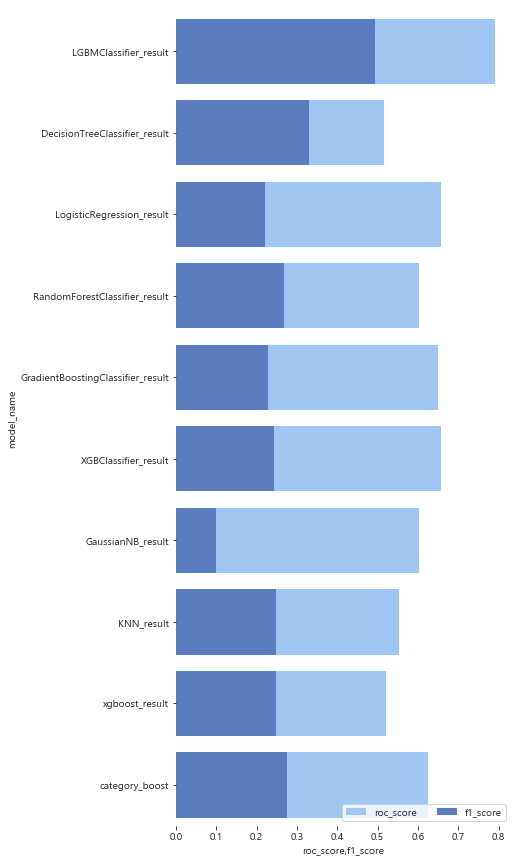

In [76]:
# sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")

sns.barplot(x="roc_score", y="model_name", data=final_data,
            label="roc_score", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="f1_score", y="model_name", data=final_data,
            label="f1_score", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="model_name",
       xlabel="roc_score,f1_score")
sns.despine(left=True, bottom=True)

## 7. 하이퍼 파리미터 조정 

In [58]:
# 1) 기본 파라미터  --> F1: 0.44145508328344546
lgbm_wrapper = LGBMClassifier(random_state=156)


# 2) 파라미터 조정 후  --> F1: 0.5588771418155305
# lgbm_wrapper = LGBMClassifier(n_estimators=50429, learning_rate=1, max_depth=100, num_leaves= 5000, random_state=156)

evals = [(X_valid, y_valid)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='f1_score', eval_set=evals, verbose=True)

preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.540737
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.56083
[3]	valid_0's binary_logloss: 0.588324
[4]	valid_0's binary_logloss: 0.616081
[5]	valid_0's binary_logloss: 0.641731
[6]	valid_0's binary_logloss: 0.666023
[7]	valid_0's binary_logloss: 0.688411
[8]	valid_0's binary_logloss: 0.706577
[9]	valid_0's binary_logloss: 0.725681
[10]	valid_0's binary_logloss: 0.745755
[11]	valid_0's binary_logloss: 0.763957
[12]	valid_0's binary_logloss: 0.781322
[13]	valid_0's binary_logloss: 0.796526
[14]	valid_0's binary_logloss: 0.812599
[15]	valid_0's binary_logloss: 0.827827
[16]	valid_0's binary_logloss: 0.840888
[17]	valid_0's binary_logloss: 0.856531
[18]	valid_0's binary_logloss: 0.869869
[19]	valid_0's binary_logloss: 0.883281
[20]	valid_0's binary_logloss: 0.897467
[21]	valid_0's binary_logloss: 0.912227
[22]	valid_0's binary_logloss: 0.924687
[23]	valid_0's binary_logloss: 0.937668
[24]	valid_0's binary_loglos

In [56]:
# 평가 점수 함수 생성
def get_clf_eval(y, pred, proba=None) :
    print(confusion_matrix(y, pred))
    print("정확도:", accuracy_score(y, pred))
    print("F1:", f1_score(y, pred))
    print("정밀도:", precision_score(y, pred))
    print("재현률(민감도):", recall_score(y, pred))
    print("ROC:", roc_auc_score(y, pred))

In [57]:
# 1) 기본 파라미터 : 예측 성능 평가  
get_clf_eval(y_test, preds, pred_proba)

[[42812  3106]
 [12755  6268]]
정확도: 0.7557629232688132
F1: 0.44145508328344546
정밀도: 0.6686579901856198
재현률(민감도): 0.3294958734163907
ROC: 0.6309267772500308


In [ ]:
# GridSearchCV로 하이퍼파라미터 조정 

In [159]:
lgbm_wrapper = LGBMClassifier(n_estimators=50429, random_state=156)

params = { 'num_leaves': [7000, 8000, 9000],
         'max_depth': [70, 80, 90],
          'learning_rate': [0.1, 0.15, 0.2]
#          'min_child_samples':[60,100],
#          'subsample':[0.8,1]
         }

gridcv = GridSearchCV(lgbm_wrapper, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='f1_score',
          eval_set=[(X_train, y_train), (X_valid, y_valid)])

# print('GridSearchCV 최적의 파라미터: ', gridcv.best_params_)
# score = f1_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
# score

[1]	valid_0's binary_logloss: 0.577452	valid_1's binary_logloss: 0.577541
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.555286	valid_1's binary_logloss: 0.556229
[3]	valid_0's binary_logloss: 0.536295	valid_1's binary_logloss: 0.538147
[4]	valid_0's binary_logloss: 0.519295	valid_1's binary_logloss: 0.521756
[5]	valid_0's binary_logloss: 0.504554	valid_1's binary_logloss: 0.5077
[6]	valid_0's binary_logloss: 0.491817	valid_1's binary_logloss: 0.495629
[7]	valid_0's binary_logloss: 0.479583	valid_1's binary_logloss: 0.484082
[8]	valid_0's binary_logloss: 0.469123	valid_1's binary_logloss: 0.473777
[9]	valid_0's binary_logloss: 0.458884	valid_1's binary_logloss: 0.46414
[10]	valid_0's binary_logloss: 0.449901	valid_1's binary_logloss: 0.455316
[11]	valid_0's binary_logloss: 0.441169	valid_1's binary_logloss: 0.447124
[12]	valid_0's binary_logloss: 0.433167	valid_1's binary_logloss: 0.439548
[13]	valid_0's binary_logloss: 0.425683	valid_1's b

[110]	valid_0's binary_logloss: 0.223787	valid_1's binary_logloss: 0.250739
[111]	valid_0's binary_logloss: 0.223554	valid_1's binary_logloss: 0.25046
[112]	valid_0's binary_logloss: 0.22339	valid_1's binary_logloss: 0.250463
[113]	valid_0's binary_logloss: 0.223152	valid_1's binary_logloss: 0.250342
[114]	valid_0's binary_logloss: 0.22297	valid_1's binary_logloss: 0.25026
[115]	valid_0's binary_logloss: 0.222867	valid_1's binary_logloss: 0.250161
[116]	valid_0's binary_logloss: 0.222695	valid_1's binary_logloss: 0.250096
[117]	valid_0's binary_logloss: 0.222592	valid_1's binary_logloss: 0.249903
[118]	valid_0's binary_logloss: 0.222489	valid_1's binary_logloss: 0.250013
[119]	valid_0's binary_logloss: 0.222408	valid_1's binary_logloss: 0.250001
[120]	valid_0's binary_logloss: 0.222262	valid_1's binary_logloss: 0.250186
[121]	valid_0's binary_logloss: 0.222182	valid_1's binary_logloss: 0.25017
[122]	valid_0's binary_logloss: 0.222152	valid_1's binary_logloss: 0.25037
[123]	valid_0's bi

[70]	valid_0's binary_logloss: 0.249255	valid_1's binary_logloss: 0.272646
[71]	valid_0's binary_logloss: 0.24806	valid_1's binary_logloss: 0.271672
[72]	valid_0's binary_logloss: 0.24709	valid_1's binary_logloss: 0.27076
[73]	valid_0's binary_logloss: 0.245998	valid_1's binary_logloss: 0.269841
[74]	valid_0's binary_logloss: 0.244934	valid_1's binary_logloss: 0.268915
[75]	valid_0's binary_logloss: 0.243982	valid_1's binary_logloss: 0.268097
[76]	valid_0's binary_logloss: 0.242908	valid_1's binary_logloss: 0.267326
[77]	valid_0's binary_logloss: 0.241925	valid_1's binary_logloss: 0.266613
[78]	valid_0's binary_logloss: 0.241025	valid_1's binary_logloss: 0.265851
[79]	valid_0's binary_logloss: 0.240131	valid_1's binary_logloss: 0.26522
[80]	valid_0's binary_logloss: 0.239283	valid_1's binary_logloss: 0.264608
[81]	valid_0's binary_logloss: 0.238541	valid_1's binary_logloss: 0.263862
[82]	valid_0's binary_logloss: 0.237787	valid_1's binary_logloss: 0.263271
[83]	valid_0's binary_logloss

[26]	valid_0's binary_logloss: 0.35602	valid_1's binary_logloss: 0.367586
[27]	valid_0's binary_logloss: 0.351699	valid_1's binary_logloss: 0.363636
[28]	valid_0's binary_logloss: 0.347632	valid_1's binary_logloss: 0.359746
[29]	valid_0's binary_logloss: 0.343619	valid_1's binary_logloss: 0.356059
[30]	valid_0's binary_logloss: 0.339797	valid_1's binary_logloss: 0.352526
[31]	valid_0's binary_logloss: 0.336179	valid_1's binary_logloss: 0.349294
[32]	valid_0's binary_logloss: 0.332565	valid_1's binary_logloss: 0.346035
[33]	valid_0's binary_logloss: 0.329086	valid_1's binary_logloss: 0.342769
[34]	valid_0's binary_logloss: 0.325824	valid_1's binary_logloss: 0.339764
[35]	valid_0's binary_logloss: 0.322409	valid_1's binary_logloss: 0.336682
[36]	valid_0's binary_logloss: 0.319204	valid_1's binary_logloss: 0.33374
[37]	valid_0's binary_logloss: 0.31629	valid_1's binary_logloss: 0.331239
[38]	valid_0's binary_logloss: 0.313381	valid_1's binary_logloss: 0.328502
[39]	valid_0's binary_loglos

[136]	valid_0's binary_logloss: 0.227028	valid_1's binary_logloss: 0.257771
[137]	valid_0's binary_logloss: 0.227043	valid_1's binary_logloss: 0.257844
[138]	valid_0's binary_logloss: 0.227214	valid_1's binary_logloss: 0.258221
[139]	valid_0's binary_logloss: 0.227311	valid_1's binary_logloss: 0.258392
[140]	valid_0's binary_logloss: 0.227422	valid_1's binary_logloss: 0.258671
[141]	valid_0's binary_logloss: 0.227496	valid_1's binary_logloss: 0.258813
[142]	valid_0's binary_logloss: 0.227692	valid_1's binary_logloss: 0.258974
[143]	valid_0's binary_logloss: 0.227855	valid_1's binary_logloss: 0.259354
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.227445	valid_1's binary_logloss: 0.255296
[1]	valid_0's binary_logloss: 0.577452	valid_1's binary_logloss: 0.577541
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.555286	valid_1's binary_logloss: 0.556229
[3]	valid_0's binary_logloss: 0.536296	valid_1's binary_logloss: 0.53814

[101]	valid_0's binary_logloss: 0.226527	valid_1's binary_logloss: 0.25549
[102]	valid_0's binary_logloss: 0.22611	valid_1's binary_logloss: 0.25507
[103]	valid_0's binary_logloss: 0.225772	valid_1's binary_logloss: 0.254912
[104]	valid_0's binary_logloss: 0.225417	valid_1's binary_logloss: 0.254704
[105]	valid_0's binary_logloss: 0.22514	valid_1's binary_logloss: 0.254487
[106]	valid_0's binary_logloss: 0.224848	valid_1's binary_logloss: 0.254213
[107]	valid_0's binary_logloss: 0.224584	valid_1's binary_logloss: 0.254109
[108]	valid_0's binary_logloss: 0.224284	valid_1's binary_logloss: 0.253855
[109]	valid_0's binary_logloss: 0.224093	valid_1's binary_logloss: 0.253632
[110]	valid_0's binary_logloss: 0.223852	valid_1's binary_logloss: 0.253476
[111]	valid_0's binary_logloss: 0.223639	valid_1's binary_logloss: 0.253362
[112]	valid_0's binary_logloss: 0.223334	valid_1's binary_logloss: 0.253056
[113]	valid_0's binary_logloss: 0.223171	valid_1's binary_logloss: 0.253149
[114]	valid_0's 

[60]	valid_0's binary_logloss: 0.262719	valid_1's binary_logloss: 0.283527
[61]	valid_0's binary_logloss: 0.261158	valid_1's binary_logloss: 0.282254
[62]	valid_0's binary_logloss: 0.259612	valid_1's binary_logloss: 0.280751
[63]	valid_0's binary_logloss: 0.2582	valid_1's binary_logloss: 0.279589
[64]	valid_0's binary_logloss: 0.256737	valid_1's binary_logloss: 0.278351
[65]	valid_0's binary_logloss: 0.255307	valid_1's binary_logloss: 0.27707
[66]	valid_0's binary_logloss: 0.253939	valid_1's binary_logloss: 0.276093
[67]	valid_0's binary_logloss: 0.252451	valid_1's binary_logloss: 0.274927
[68]	valid_0's binary_logloss: 0.251245	valid_1's binary_logloss: 0.273648
[69]	valid_0's binary_logloss: 0.249991	valid_1's binary_logloss: 0.27272
[70]	valid_0's binary_logloss: 0.24881	valid_1's binary_logloss: 0.271689
[71]	valid_0's binary_logloss: 0.247672	valid_1's binary_logloss: 0.270681
[72]	valid_0's binary_logloss: 0.246415	valid_1's binary_logloss: 0.269608
[73]	valid_0's binary_logloss:

[21]	valid_0's binary_logloss: 0.379301	valid_1's binary_logloss: 0.389481
[22]	valid_0's binary_logloss: 0.374368	valid_1's binary_logloss: 0.384843
[23]	valid_0's binary_logloss: 0.369524	valid_1's binary_logloss: 0.380299
[24]	valid_0's binary_logloss: 0.364904	valid_1's binary_logloss: 0.375711
[25]	valid_0's binary_logloss: 0.360485	valid_1's binary_logloss: 0.371531
[26]	valid_0's binary_logloss: 0.356097	valid_1's binary_logloss: 0.367499
[27]	valid_0's binary_logloss: 0.351783	valid_1's binary_logloss: 0.363182
[28]	valid_0's binary_logloss: 0.347653	valid_1's binary_logloss: 0.359289
[29]	valid_0's binary_logloss: 0.3436	valid_1's binary_logloss: 0.355558
[30]	valid_0's binary_logloss: 0.339795	valid_1's binary_logloss: 0.352035
[31]	valid_0's binary_logloss: 0.336	valid_1's binary_logloss: 0.348568
[32]	valid_0's binary_logloss: 0.332364	valid_1's binary_logloss: 0.345177
[33]	valid_0's binary_logloss: 0.328902	valid_1's binary_logloss: 0.342238
[34]	valid_0's binary_logloss:

[131]	valid_0's binary_logloss: 0.226448	valid_1's binary_logloss: 0.252665
[132]	valid_0's binary_logloss: 0.226515	valid_1's binary_logloss: 0.252762
[133]	valid_0's binary_logloss: 0.226496	valid_1's binary_logloss: 0.252848
[134]	valid_0's binary_logloss: 0.226642	valid_1's binary_logloss: 0.253043
[135]	valid_0's binary_logloss: 0.22661	valid_1's binary_logloss: 0.25311
[136]	valid_0's binary_logloss: 0.226703	valid_1's binary_logloss: 0.253201
[137]	valid_0's binary_logloss: 0.226845	valid_1's binary_logloss: 0.253548
[138]	valid_0's binary_logloss: 0.226944	valid_1's binary_logloss: 0.253716
[139]	valid_0's binary_logloss: 0.22697	valid_1's binary_logloss: 0.25394
[140]	valid_0's binary_logloss: 0.227068	valid_1's binary_logloss: 0.254171
[141]	valid_0's binary_logloss: 0.227246	valid_1's binary_logloss: 0.254407
[142]	valid_0's binary_logloss: 0.227464	valid_1's binary_logloss: 0.254763
[143]	valid_0's binary_logloss: 0.227638	valid_1's binary_logloss: 0.255039
[144]	valid_0's 

[94]	valid_0's binary_logloss: 0.229488	valid_1's binary_logloss: 0.257038
[95]	valid_0's binary_logloss: 0.228957	valid_1's binary_logloss: 0.256638
[96]	valid_0's binary_logloss: 0.228528	valid_1's binary_logloss: 0.256378
[97]	valid_0's binary_logloss: 0.228136	valid_1's binary_logloss: 0.256107
[98]	valid_0's binary_logloss: 0.227733	valid_1's binary_logloss: 0.256109
[99]	valid_0's binary_logloss: 0.227321	valid_1's binary_logloss: 0.255991
[100]	valid_0's binary_logloss: 0.22689	valid_1's binary_logloss: 0.255817
[101]	valid_0's binary_logloss: 0.226527	valid_1's binary_logloss: 0.25549
[102]	valid_0's binary_logloss: 0.22611	valid_1's binary_logloss: 0.25507
[103]	valid_0's binary_logloss: 0.225772	valid_1's binary_logloss: 0.254912
[104]	valid_0's binary_logloss: 0.225417	valid_1's binary_logloss: 0.254704
[105]	valid_0's binary_logloss: 0.22514	valid_1's binary_logloss: 0.254487
[106]	valid_0's binary_logloss: 0.224848	valid_1's binary_logloss: 0.254213
[107]	valid_0's binary_

[53]	valid_0's binary_logloss: 0.274935	valid_1's binary_logloss: 0.294326
[54]	valid_0's binary_logloss: 0.272962	valid_1's binary_logloss: 0.292764
[55]	valid_0's binary_logloss: 0.271066	valid_1's binary_logloss: 0.291107
[56]	valid_0's binary_logloss: 0.269322	valid_1's binary_logloss: 0.289646
[57]	valid_0's binary_logloss: 0.267597	valid_1's binary_logloss: 0.288063
[58]	valid_0's binary_logloss: 0.265908	valid_1's binary_logloss: 0.286491
[59]	valid_0's binary_logloss: 0.264318	valid_1's binary_logloss: 0.285081
[60]	valid_0's binary_logloss: 0.262719	valid_1's binary_logloss: 0.283527
[61]	valid_0's binary_logloss: 0.261158	valid_1's binary_logloss: 0.282254
[62]	valid_0's binary_logloss: 0.259612	valid_1's binary_logloss: 0.280751
[63]	valid_0's binary_logloss: 0.2582	valid_1's binary_logloss: 0.279589
[64]	valid_0's binary_logloss: 0.256737	valid_1's binary_logloss: 0.278351
[65]	valid_0's binary_logloss: 0.255307	valid_1's binary_logloss: 0.27707
[66]	valid_0's binary_loglos

[14]	valid_0's binary_logloss: 0.420546	valid_1's binary_logloss: 0.427499
[15]	valid_0's binary_logloss: 0.414076	valid_1's binary_logloss: 0.421634
[16]	valid_0's binary_logloss: 0.407598	valid_1's binary_logloss: 0.415694
[17]	valid_0's binary_logloss: 0.401207	valid_1's binary_logloss: 0.409929
[18]	valid_0's binary_logloss: 0.395262	valid_1's binary_logloss: 0.40453
[19]	valid_0's binary_logloss: 0.389713	valid_1's binary_logloss: 0.399406
[20]	valid_0's binary_logloss: 0.384517	valid_1's binary_logloss: 0.394613
[21]	valid_0's binary_logloss: 0.379301	valid_1's binary_logloss: 0.389481
[22]	valid_0's binary_logloss: 0.374368	valid_1's binary_logloss: 0.384843
[23]	valid_0's binary_logloss: 0.369524	valid_1's binary_logloss: 0.380299
[24]	valid_0's binary_logloss: 0.364904	valid_1's binary_logloss: 0.375711
[25]	valid_0's binary_logloss: 0.360485	valid_1's binary_logloss: 0.371531
[26]	valid_0's binary_logloss: 0.356097	valid_1's binary_logloss: 0.367499
[27]	valid_0's binary_logl

[124]	valid_0's binary_logloss: 0.226235	valid_1's binary_logloss: 0.252179
[125]	valid_0's binary_logloss: 0.226139	valid_1's binary_logloss: 0.252007
[126]	valid_0's binary_logloss: 0.226232	valid_1's binary_logloss: 0.25216
[127]	valid_0's binary_logloss: 0.226234	valid_1's binary_logloss: 0.252135
[128]	valid_0's binary_logloss: 0.226252	valid_1's binary_logloss: 0.252186
[129]	valid_0's binary_logloss: 0.226282	valid_1's binary_logloss: 0.252104
[130]	valid_0's binary_logloss: 0.226362	valid_1's binary_logloss: 0.252451
[131]	valid_0's binary_logloss: 0.226448	valid_1's binary_logloss: 0.252665
[132]	valid_0's binary_logloss: 0.226515	valid_1's binary_logloss: 0.252762
[133]	valid_0's binary_logloss: 0.226496	valid_1's binary_logloss: 0.252848
[134]	valid_0's binary_logloss: 0.226642	valid_1's binary_logloss: 0.253043
[135]	valid_0's binary_logloss: 0.22661	valid_1's binary_logloss: 0.25311
[136]	valid_0's binary_logloss: 0.226703	valid_1's binary_logloss: 0.253201
[137]	valid_0's

[87]	valid_0's binary_logloss: 0.233393	valid_1's binary_logloss: 0.258019
[88]	valid_0's binary_logloss: 0.232759	valid_1's binary_logloss: 0.257362
[89]	valid_0's binary_logloss: 0.232184	valid_1's binary_logloss: 0.256709
[90]	valid_0's binary_logloss: 0.231545	valid_1's binary_logloss: 0.256173
[91]	valid_0's binary_logloss: 0.230991	valid_1's binary_logloss: 0.255637
[92]	valid_0's binary_logloss: 0.230456	valid_1's binary_logloss: 0.255215
[93]	valid_0's binary_logloss: 0.229972	valid_1's binary_logloss: 0.254758
[94]	valid_0's binary_logloss: 0.22948	valid_1's binary_logloss: 0.254449
[95]	valid_0's binary_logloss: 0.228944	valid_1's binary_logloss: 0.254026
[96]	valid_0's binary_logloss: 0.228492	valid_1's binary_logloss: 0.253948
[97]	valid_0's binary_logloss: 0.228096	valid_1's binary_logloss: 0.253799
[98]	valid_0's binary_logloss: 0.227728	valid_1's binary_logloss: 0.25355
[99]	valid_0's binary_logloss: 0.227365	valid_1's binary_logloss: 0.253406
[100]	valid_0's binary_logl

[47]	valid_0's binary_logloss: 0.287676	valid_1's binary_logloss: 0.306276
[48]	valid_0's binary_logloss: 0.285366	valid_1's binary_logloss: 0.304282
[49]	valid_0's binary_logloss: 0.28314	valid_1's binary_logloss: 0.302187
[50]	valid_0's binary_logloss: 0.280992	valid_1's binary_logloss: 0.300073
[51]	valid_0's binary_logloss: 0.278926	valid_1's binary_logloss: 0.298075
[52]	valid_0's binary_logloss: 0.27673	valid_1's binary_logloss: 0.296219
[53]	valid_0's binary_logloss: 0.274768	valid_1's binary_logloss: 0.294404
[54]	valid_0's binary_logloss: 0.272909	valid_1's binary_logloss: 0.292772
[55]	valid_0's binary_logloss: 0.271125	valid_1's binary_logloss: 0.291285
[56]	valid_0's binary_logloss: 0.269178	valid_1's binary_logloss: 0.289362
[57]	valid_0's binary_logloss: 0.267439	valid_1's binary_logloss: 0.287826
[58]	valid_0's binary_logloss: 0.26581	valid_1's binary_logloss: 0.286271
[59]	valid_0's binary_logloss: 0.264162	valid_1's binary_logloss: 0.285046
[60]	valid_0's binary_loglos

[3]	valid_0's binary_logloss: 0.535992	valid_1's binary_logloss: 0.53643
[4]	valid_0's binary_logloss: 0.519653	valid_1's binary_logloss: 0.520728
[5]	valid_0's binary_logloss: 0.505397	valid_1's binary_logloss: 0.507232
[6]	valid_0's binary_logloss: 0.492343	valid_1's binary_logloss: 0.494815
[7]	valid_0's binary_logloss: 0.480681	valid_1's binary_logloss: 0.484019
[8]	valid_0's binary_logloss: 0.470078	valid_1's binary_logloss: 0.474069
[9]	valid_0's binary_logloss: 0.460253	valid_1's binary_logloss: 0.464858
[10]	valid_0's binary_logloss: 0.451347	valid_1's binary_logloss: 0.456164
[11]	valid_0's binary_logloss: 0.442888	valid_1's binary_logloss: 0.448018
[12]	valid_0's binary_logloss: 0.435144	valid_1's binary_logloss: 0.440674
[13]	valid_0's binary_logloss: 0.427891	valid_1's binary_logloss: 0.433856
[14]	valid_0's binary_logloss: 0.420524	valid_1's binary_logloss: 0.427421
[15]	valid_0's binary_logloss: 0.413995	valid_1's binary_logloss: 0.421175
[16]	valid_0's binary_logloss: 0.

[113]	valid_0's binary_logloss: 0.227445	valid_1's binary_logloss: 0.255296
[114]	valid_0's binary_logloss: 0.227353	valid_1's binary_logloss: 0.255479
[115]	valid_0's binary_logloss: 0.227188	valid_1's binary_logloss: 0.255413
[116]	valid_0's binary_logloss: 0.22709	valid_1's binary_logloss: 0.255351
[117]	valid_0's binary_logloss: 0.227021	valid_1's binary_logloss: 0.255452
[118]	valid_0's binary_logloss: 0.226906	valid_1's binary_logloss: 0.255497
[119]	valid_0's binary_logloss: 0.22687	valid_1's binary_logloss: 0.255934
[120]	valid_0's binary_logloss: 0.226693	valid_1's binary_logloss: 0.255955
[121]	valid_0's binary_logloss: 0.226665	valid_1's binary_logloss: 0.256089
[122]	valid_0's binary_logloss: 0.226574	valid_1's binary_logloss: 0.25606
[123]	valid_0's binary_logloss: 0.226606	valid_1's binary_logloss: 0.256418
[124]	valid_0's binary_logloss: 0.226457	valid_1's binary_logloss: 0.256378
[125]	valid_0's binary_logloss: 0.226407	valid_1's binary_logloss: 0.256545
[126]	valid_0's

[77]	valid_0's binary_logloss: 0.241086	valid_1's binary_logloss: 0.265264
[78]	valid_0's binary_logloss: 0.240182	valid_1's binary_logloss: 0.264608
[79]	valid_0's binary_logloss: 0.239354	valid_1's binary_logloss: 0.264018
[80]	valid_0's binary_logloss: 0.23843	valid_1's binary_logloss: 0.263272
[81]	valid_0's binary_logloss: 0.237648	valid_1's binary_logloss: 0.262508
[82]	valid_0's binary_logloss: 0.236818	valid_1's binary_logloss: 0.261995
[83]	valid_0's binary_logloss: 0.236104	valid_1's binary_logloss: 0.261737
[84]	valid_0's binary_logloss: 0.235415	valid_1's binary_logloss: 0.261165
[85]	valid_0's binary_logloss: 0.2347	valid_1's binary_logloss: 0.260769
[86]	valid_0's binary_logloss: 0.233947	valid_1's binary_logloss: 0.260168
[87]	valid_0's binary_logloss: 0.233338	valid_1's binary_logloss: 0.259697
[88]	valid_0's binary_logloss: 0.2327	valid_1's binary_logloss: 0.259335
[89]	valid_0's binary_logloss: 0.232102	valid_1's binary_logloss: 0.258818
[90]	valid_0's binary_logloss:

[36]	valid_0's binary_logloss: 0.3179	valid_1's binary_logloss: 0.333475
[37]	valid_0's binary_logloss: 0.314719	valid_1's binary_logloss: 0.33045
[38]	valid_0's binary_logloss: 0.311524	valid_1's binary_logloss: 0.327558
[39]	valid_0's binary_logloss: 0.30859	valid_1's binary_logloss: 0.324764
[40]	valid_0's binary_logloss: 0.30563	valid_1's binary_logloss: 0.322283
[41]	valid_0's binary_logloss: 0.302841	valid_1's binary_logloss: 0.320057
[42]	valid_0's binary_logloss: 0.300188	valid_1's binary_logloss: 0.317553
[43]	valid_0's binary_logloss: 0.297601	valid_1's binary_logloss: 0.315189
[44]	valid_0's binary_logloss: 0.295002	valid_1's binary_logloss: 0.312725
[45]	valid_0's binary_logloss: 0.292552	valid_1's binary_logloss: 0.310512
[46]	valid_0's binary_logloss: 0.290054	valid_1's binary_logloss: 0.308024
[47]	valid_0's binary_logloss: 0.287724	valid_1's binary_logloss: 0.306005
[48]	valid_0's binary_logloss: 0.285426	valid_1's binary_logloss: 0.303772
[49]	valid_0's binary_logloss:

[145]	valid_0's binary_logloss: 0.224177	valid_1's binary_logloss: 0.257567
[146]	valid_0's binary_logloss: 0.224385	valid_1's binary_logloss: 0.257874
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.223642	valid_1's binary_logloss: 0.253062
[1]	valid_0's binary_logloss: 0.577477	valid_1's binary_logloss: 0.577068
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.554957	valid_1's binary_logloss: 0.55483
[3]	valid_0's binary_logloss: 0.535992	valid_1's binary_logloss: 0.536429
[4]	valid_0's binary_logloss: 0.519653	valid_1's binary_logloss: 0.520727
[5]	valid_0's binary_logloss: 0.505397	valid_1's binary_logloss: 0.507231
[6]	valid_0's binary_logloss: 0.492343	valid_1's binary_logloss: 0.494816
[7]	valid_0's binary_logloss: 0.480674	valid_1's binary_logloss: 0.484021
[8]	valid_0's binary_logloss: 0.470072	valid_1's binary_logloss: 0.474066
[9]	valid_0's binary_logloss: 0.460245	valid_1's binary_logloss: 0.464857
[10]	valid_

[107]	valid_0's binary_logloss: 0.228191	valid_1's binary_logloss: 0.252879
[108]	valid_0's binary_logloss: 0.227898	valid_1's binary_logloss: 0.25283
[109]	valid_0's binary_logloss: 0.227692	valid_1's binary_logloss: 0.252631
[110]	valid_0's binary_logloss: 0.227417	valid_1's binary_logloss: 0.252457
[111]	valid_0's binary_logloss: 0.227278	valid_1's binary_logloss: 0.252261
[112]	valid_0's binary_logloss: 0.227051	valid_1's binary_logloss: 0.252086
[113]	valid_0's binary_logloss: 0.226939	valid_1's binary_logloss: 0.252096
[114]	valid_0's binary_logloss: 0.226844	valid_1's binary_logloss: 0.252012
[115]	valid_0's binary_logloss: 0.226695	valid_1's binary_logloss: 0.252005
[116]	valid_0's binary_logloss: 0.226623	valid_1's binary_logloss: 0.25208
[117]	valid_0's binary_logloss: 0.226599	valid_1's binary_logloss: 0.252138
[118]	valid_0's binary_logloss: 0.226521	valid_1's binary_logloss: 0.252157
[119]	valid_0's binary_logloss: 0.226374	valid_1's binary_logloss: 0.252136
[120]	valid_0'

[69]	valid_0's binary_logloss: 0.249367	valid_1's binary_logloss: 0.271919
[70]	valid_0's binary_logloss: 0.248251	valid_1's binary_logloss: 0.270966
[71]	valid_0's binary_logloss: 0.247128	valid_1's binary_logloss: 0.270115
[72]	valid_0's binary_logloss: 0.245964	valid_1's binary_logloss: 0.269073
[73]	valid_0's binary_logloss: 0.24495	valid_1's binary_logloss: 0.268218
[74]	valid_0's binary_logloss: 0.24396	valid_1's binary_logloss: 0.267491
[75]	valid_0's binary_logloss: 0.242902	valid_1's binary_logloss: 0.266688
[76]	valid_0's binary_logloss: 0.242075	valid_1's binary_logloss: 0.266048
[77]	valid_0's binary_logloss: 0.241086	valid_1's binary_logloss: 0.265264
[78]	valid_0's binary_logloss: 0.240182	valid_1's binary_logloss: 0.264608
[79]	valid_0's binary_logloss: 0.239354	valid_1's binary_logloss: 0.264018
[80]	valid_0's binary_logloss: 0.23843	valid_1's binary_logloss: 0.263272
[81]	valid_0's binary_logloss: 0.237648	valid_1's binary_logloss: 0.262508
[82]	valid_0's binary_loglos

[28]	valid_0's binary_logloss: 0.34664	valid_1's binary_logloss: 0.360089
[29]	valid_0's binary_logloss: 0.342728	valid_1's binary_logloss: 0.356476
[30]	valid_0's binary_logloss: 0.338945	valid_1's binary_logloss: 0.352908
[31]	valid_0's binary_logloss: 0.335228	valid_1's binary_logloss: 0.349297
[32]	valid_0's binary_logloss: 0.331452	valid_1's binary_logloss: 0.34565
[33]	valid_0's binary_logloss: 0.32791	valid_1's binary_logloss: 0.34255
[34]	valid_0's binary_logloss: 0.324476	valid_1's binary_logloss: 0.339169
[35]	valid_0's binary_logloss: 0.321144	valid_1's binary_logloss: 0.336445
[36]	valid_0's binary_logloss: 0.3179	valid_1's binary_logloss: 0.333475
[37]	valid_0's binary_logloss: 0.314719	valid_1's binary_logloss: 0.33045
[38]	valid_0's binary_logloss: 0.311524	valid_1's binary_logloss: 0.327558
[39]	valid_0's binary_logloss: 0.30859	valid_1's binary_logloss: 0.324764
[40]	valid_0's binary_logloss: 0.30563	valid_1's binary_logloss: 0.322283
[41]	valid_0's binary_logloss: 0.3

[138]	valid_0's binary_logloss: 0.223359	valid_1's binary_logloss: 0.255949
[139]	valid_0's binary_logloss: 0.223511	valid_1's binary_logloss: 0.256279
[140]	valid_0's binary_logloss: 0.223645	valid_1's binary_logloss: 0.25678
[141]	valid_0's binary_logloss: 0.223667	valid_1's binary_logloss: 0.256968
[142]	valid_0's binary_logloss: 0.223767	valid_1's binary_logloss: 0.257015
[143]	valid_0's binary_logloss: 0.223907	valid_1's binary_logloss: 0.257124
[144]	valid_0's binary_logloss: 0.2241	valid_1's binary_logloss: 0.257395
[145]	valid_0's binary_logloss: 0.224177	valid_1's binary_logloss: 0.257567
[146]	valid_0's binary_logloss: 0.224385	valid_1's binary_logloss: 0.257874
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.223642	valid_1's binary_logloss: 0.253062
[1]	valid_0's binary_logloss: 0.577477	valid_1's binary_logloss: 0.577068
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.554957	valid_1's binary_logloss: 0.55483


[100]	valid_0's binary_logloss: 0.230171	valid_1's binary_logloss: 0.254427
[101]	valid_0's binary_logloss: 0.229841	valid_1's binary_logloss: 0.254155
[102]	valid_0's binary_logloss: 0.229491	valid_1's binary_logloss: 0.253868
[103]	valid_0's binary_logloss: 0.22924	valid_1's binary_logloss: 0.253642
[104]	valid_0's binary_logloss: 0.228961	valid_1's binary_logloss: 0.253427
[105]	valid_0's binary_logloss: 0.228661	valid_1's binary_logloss: 0.253331
[106]	valid_0's binary_logloss: 0.228433	valid_1's binary_logloss: 0.253092
[107]	valid_0's binary_logloss: 0.228191	valid_1's binary_logloss: 0.252879
[108]	valid_0's binary_logloss: 0.227898	valid_1's binary_logloss: 0.25283
[109]	valid_0's binary_logloss: 0.227692	valid_1's binary_logloss: 0.252631
[110]	valid_0's binary_logloss: 0.227417	valid_1's binary_logloss: 0.252457
[111]	valid_0's binary_logloss: 0.227278	valid_1's binary_logloss: 0.252261
[112]	valid_0's binary_logloss: 0.227051	valid_1's binary_logloss: 0.252086
[113]	valid_0'

[62]	valid_0's binary_logloss: 0.258817	valid_1's binary_logloss: 0.279502
[63]	valid_0's binary_logloss: 0.25742	valid_1's binary_logloss: 0.278366
[64]	valid_0's binary_logloss: 0.255996	valid_1's binary_logloss: 0.27718
[65]	valid_0's binary_logloss: 0.254745	valid_1's binary_logloss: 0.276154
[66]	valid_0's binary_logloss: 0.253419	valid_1's binary_logloss: 0.27519
[67]	valid_0's binary_logloss: 0.252124	valid_1's binary_logloss: 0.274242
[68]	valid_0's binary_logloss: 0.250866	valid_1's binary_logloss: 0.273183
[69]	valid_0's binary_logloss: 0.249511	valid_1's binary_logloss: 0.271925
[70]	valid_0's binary_logloss: 0.24838	valid_1's binary_logloss: 0.270881
[71]	valid_0's binary_logloss: 0.247277	valid_1's binary_logloss: 0.269794
[72]	valid_0's binary_logloss: 0.246063	valid_1's binary_logloss: 0.268647
[73]	valid_0's binary_logloss: 0.245021	valid_1's binary_logloss: 0.26772
[74]	valid_0's binary_logloss: 0.243908	valid_1's binary_logloss: 0.26684
[75]	valid_0's binary_logloss: 

[22]	valid_0's binary_logloss: 0.373562	valid_1's binary_logloss: 0.385901
[23]	valid_0's binary_logloss: 0.368818	valid_1's binary_logloss: 0.381266
[24]	valid_0's binary_logloss: 0.364113	valid_1's binary_logloss: 0.377069
[25]	valid_0's binary_logloss: 0.35975	valid_1's binary_logloss: 0.372864
[26]	valid_0's binary_logloss: 0.35531	valid_1's binary_logloss: 0.368787
[27]	valid_0's binary_logloss: 0.351095	valid_1's binary_logloss: 0.364952
[28]	valid_0's binary_logloss: 0.346955	valid_1's binary_logloss: 0.361278
[29]	valid_0's binary_logloss: 0.34292	valid_1's binary_logloss: 0.357259
[30]	valid_0's binary_logloss: 0.339151	valid_1's binary_logloss: 0.353581
[31]	valid_0's binary_logloss: 0.335366	valid_1's binary_logloss: 0.35013
[32]	valid_0's binary_logloss: 0.331708	valid_1's binary_logloss: 0.346648
[33]	valid_0's binary_logloss: 0.328193	valid_1's binary_logloss: 0.34327
[34]	valid_0's binary_logloss: 0.324588	valid_1's binary_logloss: 0.340116
[35]	valid_0's binary_logloss:

[132]	valid_0's binary_logloss: 0.223246	valid_1's binary_logloss: 0.25441
[133]	valid_0's binary_logloss: 0.223274	valid_1's binary_logloss: 0.254608
[134]	valid_0's binary_logloss: 0.223312	valid_1's binary_logloss: 0.254765
[135]	valid_0's binary_logloss: 0.223383	valid_1's binary_logloss: 0.254916
[136]	valid_0's binary_logloss: 0.223483	valid_1's binary_logloss: 0.255133
[137]	valid_0's binary_logloss: 0.223569	valid_1's binary_logloss: 0.255359
[138]	valid_0's binary_logloss: 0.223679	valid_1's binary_logloss: 0.255715
[139]	valid_0's binary_logloss: 0.223751	valid_1's binary_logloss: 0.255823
[140]	valid_0's binary_logloss: 0.223865	valid_1's binary_logloss: 0.256093
[141]	valid_0's binary_logloss: 0.224002	valid_1's binary_logloss: 0.256354
[142]	valid_0's binary_logloss: 0.224145	valid_1's binary_logloss: 0.256486
[143]	valid_0's binary_logloss: 0.224274	valid_1's binary_logloss: 0.256707
[144]	valid_0's binary_logloss: 0.224398	valid_1's binary_logloss: 0.256941
[145]	valid_0

[89]	valid_0's binary_logloss: 0.235648	valid_1's binary_logloss: 0.260547
[90]	valid_0's binary_logloss: 0.235	valid_1's binary_logloss: 0.260095
[91]	valid_0's binary_logloss: 0.234472	valid_1's binary_logloss: 0.259669
[92]	valid_0's binary_logloss: 0.234046	valid_1's binary_logloss: 0.259591
[93]	valid_0's binary_logloss: 0.233463	valid_1's binary_logloss: 0.259307
[94]	valid_0's binary_logloss: 0.233066	valid_1's binary_logloss: 0.259053
[95]	valid_0's binary_logloss: 0.232527	valid_1's binary_logloss: 0.258545
[96]	valid_0's binary_logloss: 0.232108	valid_1's binary_logloss: 0.2582
[97]	valid_0's binary_logloss: 0.231668	valid_1's binary_logloss: 0.257914
[98]	valid_0's binary_logloss: 0.231304	valid_1's binary_logloss: 0.257558
[99]	valid_0's binary_logloss: 0.230948	valid_1's binary_logloss: 0.25714
[100]	valid_0's binary_logloss: 0.230469	valid_1's binary_logloss: 0.256729
[101]	valid_0's binary_logloss: 0.230194	valid_1's binary_logloss: 0.25671
[102]	valid_0's binary_logloss

[53]	valid_0's binary_logloss: 0.274569	valid_1's binary_logloss: 0.294167
[54]	valid_0's binary_logloss: 0.272565	valid_1's binary_logloss: 0.292509
[55]	valid_0's binary_logloss: 0.270576	valid_1's binary_logloss: 0.290667
[56]	valid_0's binary_logloss: 0.268706	valid_1's binary_logloss: 0.288808
[57]	valid_0's binary_logloss: 0.267011	valid_1's binary_logloss: 0.287485
[58]	valid_0's binary_logloss: 0.265341	valid_1's binary_logloss: 0.286166
[59]	valid_0's binary_logloss: 0.263488	valid_1's binary_logloss: 0.284751
[60]	valid_0's binary_logloss: 0.261795	valid_1's binary_logloss: 0.283153
[61]	valid_0's binary_logloss: 0.260212	valid_1's binary_logloss: 0.28166
[62]	valid_0's binary_logloss: 0.258789	valid_1's binary_logloss: 0.280347
[63]	valid_0's binary_logloss: 0.257351	valid_1's binary_logloss: 0.279093
[64]	valid_0's binary_logloss: 0.255828	valid_1's binary_logloss: 0.2777
[65]	valid_0's binary_logloss: 0.254462	valid_1's binary_logloss: 0.27661
[66]	valid_0's binary_logloss

[12]	valid_0's binary_logloss: 0.433692	valid_1's binary_logloss: 0.4406
[13]	valid_0's binary_logloss: 0.426359	valid_1's binary_logloss: 0.433516
[14]	valid_0's binary_logloss: 0.419209	valid_1's binary_logloss: 0.426398
[15]	valid_0's binary_logloss: 0.412544	valid_1's binary_logloss: 0.42033
[16]	valid_0's binary_logloss: 0.406188	valid_1's binary_logloss: 0.414339
[17]	valid_0's binary_logloss: 0.400121	valid_1's binary_logloss: 0.408776
[18]	valid_0's binary_logloss: 0.394387	valid_1's binary_logloss: 0.403359
[19]	valid_0's binary_logloss: 0.388826	valid_1's binary_logloss: 0.398136
[20]	valid_0's binary_logloss: 0.383334	valid_1's binary_logloss: 0.393167
[21]	valid_0's binary_logloss: 0.378305	valid_1's binary_logloss: 0.38864
[22]	valid_0's binary_logloss: 0.373272	valid_1's binary_logloss: 0.384039
[23]	valid_0's binary_logloss: 0.368494	valid_1's binary_logloss: 0.379692
[24]	valid_0's binary_logloss: 0.363806	valid_1's binary_logloss: 0.375545
[25]	valid_0's binary_logloss

[122]	valid_0's binary_logloss: 0.223109	valid_1's binary_logloss: 0.253708
[123]	valid_0's binary_logloss: 0.223038	valid_1's binary_logloss: 0.253787
[124]	valid_0's binary_logloss: 0.223024	valid_1's binary_logloss: 0.253763
[125]	valid_0's binary_logloss: 0.222994	valid_1's binary_logloss: 0.254002
[126]	valid_0's binary_logloss: 0.222955	valid_1's binary_logloss: 0.253987
[127]	valid_0's binary_logloss: 0.222956	valid_1's binary_logloss: 0.254138
[128]	valid_0's binary_logloss: 0.222992	valid_1's binary_logloss: 0.254532
[129]	valid_0's binary_logloss: 0.222979	valid_1's binary_logloss: 0.254691
[130]	valid_0's binary_logloss: 0.222998	valid_1's binary_logloss: 0.254769
[131]	valid_0's binary_logloss: 0.223089	valid_1's binary_logloss: 0.254914
[132]	valid_0's binary_logloss: 0.223051	valid_1's binary_logloss: 0.254887
[133]	valid_0's binary_logloss: 0.223079	valid_1's binary_logloss: 0.255163
[134]	valid_0's binary_logloss: 0.223036	valid_1's binary_logloss: 0.255261
[135]	valid_

[83]	valid_0's binary_logloss: 0.239088	valid_1's binary_logloss: 0.261155
[84]	valid_0's binary_logloss: 0.238445	valid_1's binary_logloss: 0.260661
[85]	valid_0's binary_logloss: 0.237794	valid_1's binary_logloss: 0.260122
[86]	valid_0's binary_logloss: 0.237204	valid_1's binary_logloss: 0.2596
[87]	valid_0's binary_logloss: 0.236515	valid_1's binary_logloss: 0.259004
[88]	valid_0's binary_logloss: 0.235851	valid_1's binary_logloss: 0.258505
[89]	valid_0's binary_logloss: 0.235361	valid_1's binary_logloss: 0.258139
[90]	valid_0's binary_logloss: 0.23488	valid_1's binary_logloss: 0.257767
[91]	valid_0's binary_logloss: 0.234204	valid_1's binary_logloss: 0.257371
[92]	valid_0's binary_logloss: 0.233711	valid_1's binary_logloss: 0.257296
[93]	valid_0's binary_logloss: 0.233209	valid_1's binary_logloss: 0.257048
[94]	valid_0's binary_logloss: 0.232817	valid_1's binary_logloss: 0.256741
[95]	valid_0's binary_logloss: 0.232246	valid_1's binary_logloss: 0.256192
[96]	valid_0's binary_loglos

[45]	valid_0's binary_logloss: 0.292208	valid_1's binary_logloss: 0.309499
[46]	valid_0's binary_logloss: 0.289654	valid_1's binary_logloss: 0.307339
[47]	valid_0's binary_logloss: 0.28724	valid_1's binary_logloss: 0.305522
[48]	valid_0's binary_logloss: 0.284906	valid_1's binary_logloss: 0.30332
[49]	valid_0's binary_logloss: 0.282649	valid_1's binary_logloss: 0.30112
[50]	valid_0's binary_logloss: 0.280609	valid_1's binary_logloss: 0.299353
[51]	valid_0's binary_logloss: 0.278493	valid_1's binary_logloss: 0.297664
[52]	valid_0's binary_logloss: 0.276527	valid_1's binary_logloss: 0.295955
[53]	valid_0's binary_logloss: 0.274569	valid_1's binary_logloss: 0.294167
[54]	valid_0's binary_logloss: 0.272565	valid_1's binary_logloss: 0.292509
[55]	valid_0's binary_logloss: 0.270576	valid_1's binary_logloss: 0.290667
[56]	valid_0's binary_logloss: 0.268706	valid_1's binary_logloss: 0.288808
[57]	valid_0's binary_logloss: 0.267011	valid_1's binary_logloss: 0.287485
[58]	valid_0's binary_loglos

[4]	valid_0's binary_logloss: 0.519374	valid_1's binary_logloss: 0.521878
[5]	valid_0's binary_logloss: 0.504736	valid_1's binary_logloss: 0.507636
[6]	valid_0's binary_logloss: 0.491669	valid_1's binary_logloss: 0.495265
[7]	valid_0's binary_logloss: 0.480136	valid_1's binary_logloss: 0.484204
[8]	valid_0's binary_logloss: 0.46937	valid_1's binary_logloss: 0.474236
[9]	valid_0's binary_logloss: 0.459448	valid_1's binary_logloss: 0.464719
[10]	valid_0's binary_logloss: 0.450417	valid_1's binary_logloss: 0.456288
[11]	valid_0's binary_logloss: 0.441646	valid_1's binary_logloss: 0.448167
[12]	valid_0's binary_logloss: 0.433692	valid_1's binary_logloss: 0.4406
[13]	valid_0's binary_logloss: 0.426359	valid_1's binary_logloss: 0.433516
[14]	valid_0's binary_logloss: 0.419209	valid_1's binary_logloss: 0.426398
[15]	valid_0's binary_logloss: 0.412544	valid_1's binary_logloss: 0.42033
[16]	valid_0's binary_logloss: 0.406188	valid_1's binary_logloss: 0.414339
[17]	valid_0's binary_logloss: 0.40

[114]	valid_0's binary_logloss: 0.224	valid_1's binary_logloss: 0.25336
[115]	valid_0's binary_logloss: 0.223786	valid_1's binary_logloss: 0.253135
[116]	valid_0's binary_logloss: 0.223642	valid_1's binary_logloss: 0.253062
[117]	valid_0's binary_logloss: 0.223478	valid_1's binary_logloss: 0.253094
[118]	valid_0's binary_logloss: 0.223352	valid_1's binary_logloss: 0.253078
[119]	valid_0's binary_logloss: 0.223322	valid_1's binary_logloss: 0.253321
[120]	valid_0's binary_logloss: 0.223202	valid_1's binary_logloss: 0.253255
[121]	valid_0's binary_logloss: 0.223202	valid_1's binary_logloss: 0.253657
[122]	valid_0's binary_logloss: 0.223109	valid_1's binary_logloss: 0.253708
[123]	valid_0's binary_logloss: 0.223038	valid_1's binary_logloss: 0.253787
[124]	valid_0's binary_logloss: 0.223024	valid_1's binary_logloss: 0.253763
[125]	valid_0's binary_logloss: 0.222994	valid_1's binary_logloss: 0.254002
[126]	valid_0's binary_logloss: 0.222955	valid_1's binary_logloss: 0.253987
[127]	valid_0's 

[75]	valid_0's binary_logloss: 0.245627	valid_1's binary_logloss: 0.267211
[76]	valid_0's binary_logloss: 0.244706	valid_1's binary_logloss: 0.266381
[77]	valid_0's binary_logloss: 0.243882	valid_1's binary_logloss: 0.265469
[78]	valid_0's binary_logloss: 0.243049	valid_1's binary_logloss: 0.264582
[79]	valid_0's binary_logloss: 0.242278	valid_1's binary_logloss: 0.263854
[80]	valid_0's binary_logloss: 0.241321	valid_1's binary_logloss: 0.263131
[81]	valid_0's binary_logloss: 0.24059	valid_1's binary_logloss: 0.26249
[82]	valid_0's binary_logloss: 0.23977	valid_1's binary_logloss: 0.261558
[83]	valid_0's binary_logloss: 0.239088	valid_1's binary_logloss: 0.261155
[84]	valid_0's binary_logloss: 0.238445	valid_1's binary_logloss: 0.260661
[85]	valid_0's binary_logloss: 0.237794	valid_1's binary_logloss: 0.260122
[86]	valid_0's binary_logloss: 0.237204	valid_1's binary_logloss: 0.2596
[87]	valid_0's binary_logloss: 0.236515	valid_1's binary_logloss: 0.259004
[88]	valid_0's binary_logloss:

[37]	valid_0's binary_logloss: 0.271928	valid_1's binary_logloss: 0.29046
[38]	valid_0's binary_logloss: 0.269306	valid_1's binary_logloss: 0.288175
[39]	valid_0's binary_logloss: 0.266817	valid_1's binary_logloss: 0.285909
[40]	valid_0's binary_logloss: 0.264229	valid_1's binary_logloss: 0.283463
[41]	valid_0's binary_logloss: 0.262138	valid_1's binary_logloss: 0.281581
[42]	valid_0's binary_logloss: 0.259924	valid_1's binary_logloss: 0.279521
[43]	valid_0's binary_logloss: 0.257856	valid_1's binary_logloss: 0.277568
[44]	valid_0's binary_logloss: 0.255861	valid_1's binary_logloss: 0.276108
[45]	valid_0's binary_logloss: 0.253973	valid_1's binary_logloss: 0.273939
[46]	valid_0's binary_logloss: 0.252271	valid_1's binary_logloss: 0.27256
[47]	valid_0's binary_logloss: 0.250608	valid_1's binary_logloss: 0.271194
[48]	valid_0's binary_logloss: 0.248979	valid_1's binary_logloss: 0.269881
[49]	valid_0's binary_logloss: 0.247475	valid_1's binary_logloss: 0.268652
[50]	valid_0's binary_loglo

[42]	valid_0's binary_logloss: 0.260091	valid_1's binary_logloss: 0.284381
[43]	valid_0's binary_logloss: 0.257913	valid_1's binary_logloss: 0.282499
[44]	valid_0's binary_logloss: 0.256033	valid_1's binary_logloss: 0.280806
[45]	valid_0's binary_logloss: 0.254243	valid_1's binary_logloss: 0.278815
[46]	valid_0's binary_logloss: 0.252135	valid_1's binary_logloss: 0.276809
[47]	valid_0's binary_logloss: 0.250591	valid_1's binary_logloss: 0.275372
[48]	valid_0's binary_logloss: 0.248975	valid_1's binary_logloss: 0.274086
[49]	valid_0's binary_logloss: 0.247454	valid_1's binary_logloss: 0.272688
[50]	valid_0's binary_logloss: 0.246084	valid_1's binary_logloss: 0.271449
[51]	valid_0's binary_logloss: 0.244696	valid_1's binary_logloss: 0.270665
[52]	valid_0's binary_logloss: 0.24318	valid_1's binary_logloss: 0.269568
[53]	valid_0's binary_logloss: 0.24199	valid_1's binary_logloss: 0.26865
[54]	valid_0's binary_logloss: 0.240808	valid_1's binary_logloss: 0.267703
[55]	valid_0's binary_loglos

[43]	valid_0's binary_logloss: 0.259993	valid_1's binary_logloss: 0.279872
[44]	valid_0's binary_logloss: 0.258189	valid_1's binary_logloss: 0.278265
[45]	valid_0's binary_logloss: 0.256148	valid_1's binary_logloss: 0.276563
[46]	valid_0's binary_logloss: 0.254431	valid_1's binary_logloss: 0.275166
[47]	valid_0's binary_logloss: 0.252832	valid_1's binary_logloss: 0.273952
[48]	valid_0's binary_logloss: 0.25127	valid_1's binary_logloss: 0.272764
[49]	valid_0's binary_logloss: 0.249824	valid_1's binary_logloss: 0.271286
[50]	valid_0's binary_logloss: 0.248252	valid_1's binary_logloss: 0.269858
[51]	valid_0's binary_logloss: 0.246991	valid_1's binary_logloss: 0.269127
[52]	valid_0's binary_logloss: 0.245744	valid_1's binary_logloss: 0.268181
[53]	valid_0's binary_logloss: 0.244654	valid_1's binary_logloss: 0.267573
[54]	valid_0's binary_logloss: 0.243318	valid_1's binary_logloss: 0.266168
[55]	valid_0's binary_logloss: 0.242343	valid_1's binary_logloss: 0.26575
[56]	valid_0's binary_loglo

[46]	valid_0's binary_logloss: 0.251477	valid_1's binary_logloss: 0.273871
[47]	valid_0's binary_logloss: 0.249806	valid_1's binary_logloss: 0.272591
[48]	valid_0's binary_logloss: 0.248248	valid_1's binary_logloss: 0.271227
[49]	valid_0's binary_logloss: 0.246717	valid_1's binary_logloss: 0.269759
[50]	valid_0's binary_logloss: 0.245299	valid_1's binary_logloss: 0.268237
[51]	valid_0's binary_logloss: 0.243878	valid_1's binary_logloss: 0.266932
[52]	valid_0's binary_logloss: 0.242493	valid_1's binary_logloss: 0.26576
[53]	valid_0's binary_logloss: 0.241161	valid_1's binary_logloss: 0.264747
[54]	valid_0's binary_logloss: 0.239948	valid_1's binary_logloss: 0.263538
[55]	valid_0's binary_logloss: 0.238855	valid_1's binary_logloss: 0.262609
[56]	valid_0's binary_logloss: 0.237824	valid_1's binary_logloss: 0.261889
[57]	valid_0's binary_logloss: 0.236802	valid_1's binary_logloss: 0.261034
[58]	valid_0's binary_logloss: 0.235891	valid_1's binary_logloss: 0.260455
[59]	valid_0's binary_logl

[45]	valid_0's binary_logloss: 0.254647	valid_1's binary_logloss: 0.279106
[46]	valid_0's binary_logloss: 0.252633	valid_1's binary_logloss: 0.277251
[47]	valid_0's binary_logloss: 0.250978	valid_1's binary_logloss: 0.275796
[48]	valid_0's binary_logloss: 0.249404	valid_1's binary_logloss: 0.274665
[49]	valid_0's binary_logloss: 0.247774	valid_1's binary_logloss: 0.273187
[50]	valid_0's binary_logloss: 0.246351	valid_1's binary_logloss: 0.272233
[51]	valid_0's binary_logloss: 0.244991	valid_1's binary_logloss: 0.271353
[52]	valid_0's binary_logloss: 0.243619	valid_1's binary_logloss: 0.270225
[53]	valid_0's binary_logloss: 0.242136	valid_1's binary_logloss: 0.26925
[54]	valid_0's binary_logloss: 0.241001	valid_1's binary_logloss: 0.268151
[55]	valid_0's binary_logloss: 0.239847	valid_1's binary_logloss: 0.267026
[56]	valid_0's binary_logloss: 0.238864	valid_1's binary_logloss: 0.266187
[57]	valid_0's binary_logloss: 0.237593	valid_1's binary_logloss: 0.265106
[58]	valid_0's binary_logl

[44]	valid_0's binary_logloss: 0.257957	valid_1's binary_logloss: 0.280186
[45]	valid_0's binary_logloss: 0.256179	valid_1's binary_logloss: 0.278487
[46]	valid_0's binary_logloss: 0.254204	valid_1's binary_logloss: 0.276728
[47]	valid_0's binary_logloss: 0.252623	valid_1's binary_logloss: 0.27538
[48]	valid_0's binary_logloss: 0.250933	valid_1's binary_logloss: 0.273745
[49]	valid_0's binary_logloss: 0.249366	valid_1's binary_logloss: 0.272645
[50]	valid_0's binary_logloss: 0.24801	valid_1's binary_logloss: 0.271387
[51]	valid_0's binary_logloss: 0.246619	valid_1's binary_logloss: 0.270189
[52]	valid_0's binary_logloss: 0.245377	valid_1's binary_logloss: 0.269122
[53]	valid_0's binary_logloss: 0.244043	valid_1's binary_logloss: 0.267797
[54]	valid_0's binary_logloss: 0.24297	valid_1's binary_logloss: 0.266589
[55]	valid_0's binary_logloss: 0.241751	valid_1's binary_logloss: 0.265751
[56]	valid_0's binary_logloss: 0.240662	valid_1's binary_logloss: 0.264825
[57]	valid_0's binary_loglos

[47]	valid_0's binary_logloss: 0.249806	valid_1's binary_logloss: 0.272591
[48]	valid_0's binary_logloss: 0.248248	valid_1's binary_logloss: 0.271227
[49]	valid_0's binary_logloss: 0.246717	valid_1's binary_logloss: 0.269759
[50]	valid_0's binary_logloss: 0.245299	valid_1's binary_logloss: 0.268237
[51]	valid_0's binary_logloss: 0.243878	valid_1's binary_logloss: 0.266932
[52]	valid_0's binary_logloss: 0.242493	valid_1's binary_logloss: 0.26576
[53]	valid_0's binary_logloss: 0.241161	valid_1's binary_logloss: 0.264747
[54]	valid_0's binary_logloss: 0.239948	valid_1's binary_logloss: 0.263538
[55]	valid_0's binary_logloss: 0.238855	valid_1's binary_logloss: 0.262609
[56]	valid_0's binary_logloss: 0.237824	valid_1's binary_logloss: 0.261889
[57]	valid_0's binary_logloss: 0.236802	valid_1's binary_logloss: 0.261034
[58]	valid_0's binary_logloss: 0.235891	valid_1's binary_logloss: 0.260455
[59]	valid_0's binary_logloss: 0.234827	valid_1's binary_logloss: 0.25962
[60]	valid_0's binary_loglo

[46]	valid_0's binary_logloss: 0.252633	valid_1's binary_logloss: 0.277251
[47]	valid_0's binary_logloss: 0.250978	valid_1's binary_logloss: 0.275796
[48]	valid_0's binary_logloss: 0.249404	valid_1's binary_logloss: 0.274665
[49]	valid_0's binary_logloss: 0.247774	valid_1's binary_logloss: 0.273187
[50]	valid_0's binary_logloss: 0.246351	valid_1's binary_logloss: 0.272233
[51]	valid_0's binary_logloss: 0.244991	valid_1's binary_logloss: 0.271353
[52]	valid_0's binary_logloss: 0.243619	valid_1's binary_logloss: 0.270225
[53]	valid_0's binary_logloss: 0.242136	valid_1's binary_logloss: 0.26925
[54]	valid_0's binary_logloss: 0.241001	valid_1's binary_logloss: 0.268151
[55]	valid_0's binary_logloss: 0.239847	valid_1's binary_logloss: 0.267026
[56]	valid_0's binary_logloss: 0.238864	valid_1's binary_logloss: 0.266187
[57]	valid_0's binary_logloss: 0.237593	valid_1's binary_logloss: 0.265106
[58]	valid_0's binary_logloss: 0.236756	valid_1's binary_logloss: 0.264529
[59]	valid_0's binary_logl

[45]	valid_0's binary_logloss: 0.256179	valid_1's binary_logloss: 0.278487
[46]	valid_0's binary_logloss: 0.254204	valid_1's binary_logloss: 0.276728
[47]	valid_0's binary_logloss: 0.252623	valid_1's binary_logloss: 0.27538
[48]	valid_0's binary_logloss: 0.250933	valid_1's binary_logloss: 0.273745
[49]	valid_0's binary_logloss: 0.249366	valid_1's binary_logloss: 0.272645
[50]	valid_0's binary_logloss: 0.24801	valid_1's binary_logloss: 0.271387
[51]	valid_0's binary_logloss: 0.246619	valid_1's binary_logloss: 0.270189
[52]	valid_0's binary_logloss: 0.245377	valid_1's binary_logloss: 0.269122
[53]	valid_0's binary_logloss: 0.244043	valid_1's binary_logloss: 0.267797
[54]	valid_0's binary_logloss: 0.24297	valid_1's binary_logloss: 0.266589
[55]	valid_0's binary_logloss: 0.241751	valid_1's binary_logloss: 0.265751
[56]	valid_0's binary_logloss: 0.240662	valid_1's binary_logloss: 0.264825
[57]	valid_0's binary_logloss: 0.239762	valid_1's binary_logloss: 0.263999
[58]	valid_0's binary_loglos

[48]	valid_0's binary_logloss: 0.248979	valid_1's binary_logloss: 0.269881
[49]	valid_0's binary_logloss: 0.247475	valid_1's binary_logloss: 0.268652
[50]	valid_0's binary_logloss: 0.245751	valid_1's binary_logloss: 0.267548
[51]	valid_0's binary_logloss: 0.244325	valid_1's binary_logloss: 0.266295
[52]	valid_0's binary_logloss: 0.242992	valid_1's binary_logloss: 0.26513
[53]	valid_0's binary_logloss: 0.241794	valid_1's binary_logloss: 0.264012
[54]	valid_0's binary_logloss: 0.240457	valid_1's binary_logloss: 0.263162
[55]	valid_0's binary_logloss: 0.239402	valid_1's binary_logloss: 0.262525
[56]	valid_0's binary_logloss: 0.238073	valid_1's binary_logloss: 0.261507
[57]	valid_0's binary_logloss: 0.237096	valid_1's binary_logloss: 0.261095
[58]	valid_0's binary_logloss: 0.236076	valid_1's binary_logloss: 0.26029
[59]	valid_0's binary_logloss: 0.235232	valid_1's binary_logloss: 0.25972
[60]	valid_0's binary_logloss: 0.234369	valid_1's binary_logloss: 0.258983
[61]	valid_0's binary_loglos

[53]	valid_0's binary_logloss: 0.24199	valid_1's binary_logloss: 0.26865
[54]	valid_0's binary_logloss: 0.240808	valid_1's binary_logloss: 0.267703
[55]	valid_0's binary_logloss: 0.239718	valid_1's binary_logloss: 0.267086
[56]	valid_0's binary_logloss: 0.238496	valid_1's binary_logloss: 0.265734
[57]	valid_0's binary_logloss: 0.237555	valid_1's binary_logloss: 0.264988
[58]	valid_0's binary_logloss: 0.236592	valid_1's binary_logloss: 0.26434
[59]	valid_0's binary_logloss: 0.235754	valid_1's binary_logloss: 0.263842
[60]	valid_0's binary_logloss: 0.234914	valid_1's binary_logloss: 0.263211
[61]	valid_0's binary_logloss: 0.23412	valid_1's binary_logloss: 0.262705
[62]	valid_0's binary_logloss: 0.233196	valid_1's binary_logloss: 0.262083
[63]	valid_0's binary_logloss: 0.23248	valid_1's binary_logloss: 0.26153
[64]	valid_0's binary_logloss: 0.231697	valid_1's binary_logloss: 0.260681
[65]	valid_0's binary_logloss: 0.231097	valid_1's binary_logloss: 0.260255
[66]	valid_0's binary_logloss: 

[54]	valid_0's binary_logloss: 0.243318	valid_1's binary_logloss: 0.266168
[55]	valid_0's binary_logloss: 0.242343	valid_1's binary_logloss: 0.26575
[56]	valid_0's binary_logloss: 0.241305	valid_1's binary_logloss: 0.265076
[57]	valid_0's binary_logloss: 0.240252	valid_1's binary_logloss: 0.26419
[58]	valid_0's binary_logloss: 0.239393	valid_1's binary_logloss: 0.263549
[59]	valid_0's binary_logloss: 0.238565	valid_1's binary_logloss: 0.263005
[60]	valid_0's binary_logloss: 0.237614	valid_1's binary_logloss: 0.262383
[61]	valid_0's binary_logloss: 0.236841	valid_1's binary_logloss: 0.261963
[62]	valid_0's binary_logloss: 0.236115	valid_1's binary_logloss: 0.261539
[63]	valid_0's binary_logloss: 0.235515	valid_1's binary_logloss: 0.261176
[64]	valid_0's binary_logloss: 0.234916	valid_1's binary_logloss: 0.260892
[65]	valid_0's binary_logloss: 0.234433	valid_1's binary_logloss: 0.260833
[66]	valid_0's binary_logloss: 0.233811	valid_1's binary_logloss: 0.26034
[67]	valid_0's binary_loglos

[57]	valid_0's binary_logloss: 0.236802	valid_1's binary_logloss: 0.261034
[58]	valid_0's binary_logloss: 0.235891	valid_1's binary_logloss: 0.260455
[59]	valid_0's binary_logloss: 0.234827	valid_1's binary_logloss: 0.25962
[60]	valid_0's binary_logloss: 0.233981	valid_1's binary_logloss: 0.25912
[61]	valid_0's binary_logloss: 0.233188	valid_1's binary_logloss: 0.258481
[62]	valid_0's binary_logloss: 0.232436	valid_1's binary_logloss: 0.258084
[63]	valid_0's binary_logloss: 0.23184	valid_1's binary_logloss: 0.257839
[64]	valid_0's binary_logloss: 0.23116	valid_1's binary_logloss: 0.257154
[65]	valid_0's binary_logloss: 0.230371	valid_1's binary_logloss: 0.256719
[66]	valid_0's binary_logloss: 0.229783	valid_1's binary_logloss: 0.256374
[67]	valid_0's binary_logloss: 0.229169	valid_1's binary_logloss: 0.255966
[68]	valid_0's binary_logloss: 0.228619	valid_1's binary_logloss: 0.255533
[69]	valid_0's binary_logloss: 0.22805	valid_1's binary_logloss: 0.255017
[70]	valid_0's binary_logloss:

[56]	valid_0's binary_logloss: 0.238864	valid_1's binary_logloss: 0.266187
[57]	valid_0's binary_logloss: 0.237593	valid_1's binary_logloss: 0.265106
[58]	valid_0's binary_logloss: 0.236756	valid_1's binary_logloss: 0.264529
[59]	valid_0's binary_logloss: 0.235885	valid_1's binary_logloss: 0.264061
[60]	valid_0's binary_logloss: 0.235046	valid_1's binary_logloss: 0.263347
[61]	valid_0's binary_logloss: 0.234289	valid_1's binary_logloss: 0.262985
[62]	valid_0's binary_logloss: 0.233421	valid_1's binary_logloss: 0.262231
[63]	valid_0's binary_logloss: 0.232762	valid_1's binary_logloss: 0.261555
[64]	valid_0's binary_logloss: 0.232182	valid_1's binary_logloss: 0.26103
[65]	valid_0's binary_logloss: 0.231585	valid_1's binary_logloss: 0.260659
[66]	valid_0's binary_logloss: 0.231078	valid_1's binary_logloss: 0.260012
[67]	valid_0's binary_logloss: 0.230478	valid_1's binary_logloss: 0.259827
[68]	valid_0's binary_logloss: 0.229788	valid_1's binary_logloss: 0.25941
[69]	valid_0's binary_loglo

[55]	valid_0's binary_logloss: 0.241751	valid_1's binary_logloss: 0.265751
[56]	valid_0's binary_logloss: 0.240662	valid_1's binary_logloss: 0.264825
[57]	valid_0's binary_logloss: 0.239762	valid_1's binary_logloss: 0.263999
[58]	valid_0's binary_logloss: 0.238916	valid_1's binary_logloss: 0.263242
[59]	valid_0's binary_logloss: 0.238035	valid_1's binary_logloss: 0.262767
[60]	valid_0's binary_logloss: 0.237071	valid_1's binary_logloss: 0.262038
[61]	valid_0's binary_logloss: 0.236273	valid_1's binary_logloss: 0.261336
[62]	valid_0's binary_logloss: 0.235535	valid_1's binary_logloss: 0.260827
[63]	valid_0's binary_logloss: 0.234879	valid_1's binary_logloss: 0.260413
[64]	valid_0's binary_logloss: 0.234077	valid_1's binary_logloss: 0.259723
[65]	valid_0's binary_logloss: 0.23354	valid_1's binary_logloss: 0.25917
[66]	valid_0's binary_logloss: 0.233027	valid_1's binary_logloss: 0.258826
[67]	valid_0's binary_logloss: 0.232524	valid_1's binary_logloss: 0.258528
[68]	valid_0's binary_loglo

[58]	valid_0's binary_logloss: 0.235891	valid_1's binary_logloss: 0.260455
[59]	valid_0's binary_logloss: 0.234827	valid_1's binary_logloss: 0.25962
[60]	valid_0's binary_logloss: 0.233981	valid_1's binary_logloss: 0.25912
[61]	valid_0's binary_logloss: 0.233188	valid_1's binary_logloss: 0.258481
[62]	valid_0's binary_logloss: 0.232436	valid_1's binary_logloss: 0.258084
[63]	valid_0's binary_logloss: 0.23184	valid_1's binary_logloss: 0.257839
[64]	valid_0's binary_logloss: 0.23116	valid_1's binary_logloss: 0.257154
[65]	valid_0's binary_logloss: 0.230371	valid_1's binary_logloss: 0.256719
[66]	valid_0's binary_logloss: 0.229783	valid_1's binary_logloss: 0.256374
[67]	valid_0's binary_logloss: 0.229169	valid_1's binary_logloss: 0.255966
[68]	valid_0's binary_logloss: 0.228619	valid_1's binary_logloss: 0.255533
[69]	valid_0's binary_logloss: 0.22805	valid_1's binary_logloss: 0.255017
[70]	valid_0's binary_logloss: 0.227571	valid_1's binary_logloss: 0.255016
[71]	valid_0's binary_logloss:

[57]	valid_0's binary_logloss: 0.237593	valid_1's binary_logloss: 0.265106
[58]	valid_0's binary_logloss: 0.236756	valid_1's binary_logloss: 0.264529
[59]	valid_0's binary_logloss: 0.235885	valid_1's binary_logloss: 0.264061
[60]	valid_0's binary_logloss: 0.235046	valid_1's binary_logloss: 0.263347
[61]	valid_0's binary_logloss: 0.234289	valid_1's binary_logloss: 0.262985
[62]	valid_0's binary_logloss: 0.233421	valid_1's binary_logloss: 0.262231
[63]	valid_0's binary_logloss: 0.232762	valid_1's binary_logloss: 0.261555
[64]	valid_0's binary_logloss: 0.232182	valid_1's binary_logloss: 0.26103
[65]	valid_0's binary_logloss: 0.231585	valid_1's binary_logloss: 0.260659
[66]	valid_0's binary_logloss: 0.231078	valid_1's binary_logloss: 0.260012
[67]	valid_0's binary_logloss: 0.230478	valid_1's binary_logloss: 0.259827
[68]	valid_0's binary_logloss: 0.229788	valid_1's binary_logloss: 0.25941
[69]	valid_0's binary_logloss: 0.229378	valid_1's binary_logloss: 0.259231
[70]	valid_0's binary_loglo

[56]	valid_0's binary_logloss: 0.240662	valid_1's binary_logloss: 0.264825
[57]	valid_0's binary_logloss: 0.239762	valid_1's binary_logloss: 0.263999
[58]	valid_0's binary_logloss: 0.238916	valid_1's binary_logloss: 0.263242
[59]	valid_0's binary_logloss: 0.238035	valid_1's binary_logloss: 0.262767
[60]	valid_0's binary_logloss: 0.237071	valid_1's binary_logloss: 0.262038
[61]	valid_0's binary_logloss: 0.236273	valid_1's binary_logloss: 0.261336
[62]	valid_0's binary_logloss: 0.235535	valid_1's binary_logloss: 0.260827
[63]	valid_0's binary_logloss: 0.234879	valid_1's binary_logloss: 0.260413
[64]	valid_0's binary_logloss: 0.234077	valid_1's binary_logloss: 0.259723
[65]	valid_0's binary_logloss: 0.23354	valid_1's binary_logloss: 0.25917
[66]	valid_0's binary_logloss: 0.233027	valid_1's binary_logloss: 0.258826
[67]	valid_0's binary_logloss: 0.232524	valid_1's binary_logloss: 0.258528
[68]	valid_0's binary_logloss: 0.232103	valid_1's binary_logloss: 0.258474
[69]	valid_0's binary_loglo

[59]	valid_0's binary_logloss: 0.235232	valid_1's binary_logloss: 0.25972
[60]	valid_0's binary_logloss: 0.234369	valid_1's binary_logloss: 0.258983
[61]	valid_0's binary_logloss: 0.233419	valid_1's binary_logloss: 0.258328
[62]	valid_0's binary_logloss: 0.232692	valid_1's binary_logloss: 0.257883
[63]	valid_0's binary_logloss: 0.232028	valid_1's binary_logloss: 0.257359
[64]	valid_0's binary_logloss: 0.231342	valid_1's binary_logloss: 0.25669
[65]	valid_0's binary_logloss: 0.23072	valid_1's binary_logloss: 0.256308
[66]	valid_0's binary_logloss: 0.230172	valid_1's binary_logloss: 0.255907
[67]	valid_0's binary_logloss: 0.229532	valid_1's binary_logloss: 0.255556
[68]	valid_0's binary_logloss: 0.229015	valid_1's binary_logloss: 0.255451
[69]	valid_0's binary_logloss: 0.228487	valid_1's binary_logloss: 0.255223
[70]	valid_0's binary_logloss: 0.228058	valid_1's binary_logloss: 0.254895
[71]	valid_0's binary_logloss: 0.227578	valid_1's binary_logloss: 0.254587
[72]	valid_0's binary_loglos

[64]	valid_0's binary_logloss: 0.231697	valid_1's binary_logloss: 0.260681
[65]	valid_0's binary_logloss: 0.231097	valid_1's binary_logloss: 0.260255
[66]	valid_0's binary_logloss: 0.230496	valid_1's binary_logloss: 0.259793
[67]	valid_0's binary_logloss: 0.230004	valid_1's binary_logloss: 0.259644
[68]	valid_0's binary_logloss: 0.229536	valid_1's binary_logloss: 0.259177
[69]	valid_0's binary_logloss: 0.229132	valid_1's binary_logloss: 0.25897
[70]	valid_0's binary_logloss: 0.228813	valid_1's binary_logloss: 0.258937
[71]	valid_0's binary_logloss: 0.228343	valid_1's binary_logloss: 0.258984
[72]	valid_0's binary_logloss: 0.227827	valid_1's binary_logloss: 0.258725
[73]	valid_0's binary_logloss: 0.22752	valid_1's binary_logloss: 0.258457
[74]	valid_0's binary_logloss: 0.22721	valid_1's binary_logloss: 0.258183
[75]	valid_0's binary_logloss: 0.227074	valid_1's binary_logloss: 0.25804
[76]	valid_0's binary_logloss: 0.226952	valid_1's binary_logloss: 0.258258
[77]	valid_0's binary_logloss

[66]	valid_0's binary_logloss: 0.233811	valid_1's binary_logloss: 0.26034
[67]	valid_0's binary_logloss: 0.233339	valid_1's binary_logloss: 0.260193
[68]	valid_0's binary_logloss: 0.232837	valid_1's binary_logloss: 0.259768
[69]	valid_0's binary_logloss: 0.232399	valid_1's binary_logloss: 0.259546
[70]	valid_0's binary_logloss: 0.232005	valid_1's binary_logloss: 0.259403
[71]	valid_0's binary_logloss: 0.231657	valid_1's binary_logloss: 0.259182
[72]	valid_0's binary_logloss: 0.231347	valid_1's binary_logloss: 0.259091
[73]	valid_0's binary_logloss: 0.231176	valid_1's binary_logloss: 0.259335
[74]	valid_0's binary_logloss: 0.230707	valid_1's binary_logloss: 0.25921
[75]	valid_0's binary_logloss: 0.230502	valid_1's binary_logloss: 0.258942
[76]	valid_0's binary_logloss: 0.23037	valid_1's binary_logloss: 0.259078
[77]	valid_0's binary_logloss: 0.230101	valid_1's binary_logloss: 0.259106
[78]	valid_0's binary_logloss: 0.230062	valid_1's binary_logloss: 0.259164
[79]	valid_0's binary_loglos

[69]	valid_0's binary_logloss: 0.22805	valid_1's binary_logloss: 0.255017
[70]	valid_0's binary_logloss: 0.227571	valid_1's binary_logloss: 0.255016
[71]	valid_0's binary_logloss: 0.227232	valid_1's binary_logloss: 0.254704
[72]	valid_0's binary_logloss: 0.226698	valid_1's binary_logloss: 0.254261
[73]	valid_0's binary_logloss: 0.226451	valid_1's binary_logloss: 0.254155
[74]	valid_0's binary_logloss: 0.22619	valid_1's binary_logloss: 0.254203
[75]	valid_0's binary_logloss: 0.225963	valid_1's binary_logloss: 0.25395
[76]	valid_0's binary_logloss: 0.225669	valid_1's binary_logloss: 0.253653
[77]	valid_0's binary_logloss: 0.225467	valid_1's binary_logloss: 0.253436
[78]	valid_0's binary_logloss: 0.225215	valid_1's binary_logloss: 0.253447
[79]	valid_0's binary_logloss: 0.225007	valid_1's binary_logloss: 0.253243
[80]	valid_0's binary_logloss: 0.224896	valid_1's binary_logloss: 0.253549
[81]	valid_0's binary_logloss: 0.224718	valid_1's binary_logloss: 0.253721
[82]	valid_0's binary_loglos

[68]	valid_0's binary_logloss: 0.229788	valid_1's binary_logloss: 0.25941
[69]	valid_0's binary_logloss: 0.229378	valid_1's binary_logloss: 0.259231
[70]	valid_0's binary_logloss: 0.229082	valid_1's binary_logloss: 0.259154
[71]	valid_0's binary_logloss: 0.228672	valid_1's binary_logloss: 0.258986
[72]	valid_0's binary_logloss: 0.228391	valid_1's binary_logloss: 0.259152
[73]	valid_0's binary_logloss: 0.227947	valid_1's binary_logloss: 0.258747
[74]	valid_0's binary_logloss: 0.227664	valid_1's binary_logloss: 0.258735
[75]	valid_0's binary_logloss: 0.227496	valid_1's binary_logloss: 0.258722
[76]	valid_0's binary_logloss: 0.227236	valid_1's binary_logloss: 0.25877
[77]	valid_0's binary_logloss: 0.227116	valid_1's binary_logloss: 0.258915
[78]	valid_0's binary_logloss: 0.226921	valid_1's binary_logloss: 0.258861
[79]	valid_0's binary_logloss: 0.226596	valid_1's binary_logloss: 0.258579
[80]	valid_0's binary_logloss: 0.226543	valid_1's binary_logloss: 0.258935
[81]	valid_0's binary_loglo

[67]	valid_0's binary_logloss: 0.232524	valid_1's binary_logloss: 0.258528
[68]	valid_0's binary_logloss: 0.232103	valid_1's binary_logloss: 0.258474
[69]	valid_0's binary_logloss: 0.231527	valid_1's binary_logloss: 0.258106
[70]	valid_0's binary_logloss: 0.231186	valid_1's binary_logloss: 0.257858
[71]	valid_0's binary_logloss: 0.230849	valid_1's binary_logloss: 0.257686
[72]	valid_0's binary_logloss: 0.230481	valid_1's binary_logloss: 0.257666
[73]	valid_0's binary_logloss: 0.230204	valid_1's binary_logloss: 0.257624
[74]	valid_0's binary_logloss: 0.230009	valid_1's binary_logloss: 0.257462
[75]	valid_0's binary_logloss: 0.229683	valid_1's binary_logloss: 0.257284
[76]	valid_0's binary_logloss: 0.22963	valid_1's binary_logloss: 0.257537
[77]	valid_0's binary_logloss: 0.229424	valid_1's binary_logloss: 0.257433
[78]	valid_0's binary_logloss: 0.229195	valid_1's binary_logloss: 0.257348
[79]	valid_0's binary_logloss: 0.229013	valid_1's binary_logloss: 0.257467
[80]	valid_0's binary_logl

[70]	valid_0's binary_logloss: 0.227571	valid_1's binary_logloss: 0.255016
[71]	valid_0's binary_logloss: 0.227232	valid_1's binary_logloss: 0.254704
[72]	valid_0's binary_logloss: 0.226698	valid_1's binary_logloss: 0.254261
[73]	valid_0's binary_logloss: 0.226451	valid_1's binary_logloss: 0.254155
[74]	valid_0's binary_logloss: 0.22619	valid_1's binary_logloss: 0.254203
[75]	valid_0's binary_logloss: 0.225963	valid_1's binary_logloss: 0.25395
[76]	valid_0's binary_logloss: 0.225669	valid_1's binary_logloss: 0.253653
[77]	valid_0's binary_logloss: 0.225467	valid_1's binary_logloss: 0.253436
[78]	valid_0's binary_logloss: 0.225215	valid_1's binary_logloss: 0.253447
[79]	valid_0's binary_logloss: 0.225007	valid_1's binary_logloss: 0.253243
[80]	valid_0's binary_logloss: 0.224896	valid_1's binary_logloss: 0.253549
[81]	valid_0's binary_logloss: 0.224718	valid_1's binary_logloss: 0.253721
[82]	valid_0's binary_logloss: 0.224685	valid_1's binary_logloss: 0.253948
[83]	valid_0's binary_loglo

[69]	valid_0's binary_logloss: 0.229378	valid_1's binary_logloss: 0.259231
[70]	valid_0's binary_logloss: 0.229082	valid_1's binary_logloss: 0.259154
[71]	valid_0's binary_logloss: 0.228672	valid_1's binary_logloss: 0.258986
[72]	valid_0's binary_logloss: 0.228391	valid_1's binary_logloss: 0.259152
[73]	valid_0's binary_logloss: 0.227947	valid_1's binary_logloss: 0.258747
[74]	valid_0's binary_logloss: 0.227664	valid_1's binary_logloss: 0.258735
[75]	valid_0's binary_logloss: 0.227496	valid_1's binary_logloss: 0.258722
[76]	valid_0's binary_logloss: 0.227236	valid_1's binary_logloss: 0.25877
[77]	valid_0's binary_logloss: 0.227116	valid_1's binary_logloss: 0.258915
[78]	valid_0's binary_logloss: 0.226921	valid_1's binary_logloss: 0.258861
[79]	valid_0's binary_logloss: 0.226596	valid_1's binary_logloss: 0.258579
[80]	valid_0's binary_logloss: 0.226543	valid_1's binary_logloss: 0.258935
[81]	valid_0's binary_logloss: 0.226465	valid_1's binary_logloss: 0.259089
[82]	valid_0's binary_logl

[68]	valid_0's binary_logloss: 0.232103	valid_1's binary_logloss: 0.258474
[69]	valid_0's binary_logloss: 0.231527	valid_1's binary_logloss: 0.258106
[70]	valid_0's binary_logloss: 0.231186	valid_1's binary_logloss: 0.257858
[71]	valid_0's binary_logloss: 0.230849	valid_1's binary_logloss: 0.257686
[72]	valid_0's binary_logloss: 0.230481	valid_1's binary_logloss: 0.257666
[73]	valid_0's binary_logloss: 0.230204	valid_1's binary_logloss: 0.257624
[74]	valid_0's binary_logloss: 0.230009	valid_1's binary_logloss: 0.257462
[75]	valid_0's binary_logloss: 0.229683	valid_1's binary_logloss: 0.257284
[76]	valid_0's binary_logloss: 0.22963	valid_1's binary_logloss: 0.257537
[77]	valid_0's binary_logloss: 0.229424	valid_1's binary_logloss: 0.257433
[78]	valid_0's binary_logloss: 0.229195	valid_1's binary_logloss: 0.257348
[79]	valid_0's binary_logloss: 0.229013	valid_1's binary_logloss: 0.257467
[80]	valid_0's binary_logloss: 0.228852	valid_1's binary_logloss: 0.257615
[81]	valid_0's binary_logl

[71]	valid_0's binary_logloss: 0.228858	valid_1's binary_logloss: 0.26082
[72]	valid_0's binary_logloss: 0.229024	valid_1's binary_logloss: 0.260945
[73]	valid_0's binary_logloss: 0.229217	valid_1's binary_logloss: 0.261427
[74]	valid_0's binary_logloss: 0.229654	valid_1's binary_logloss: 0.261984
[75]	valid_0's binary_logloss: 0.230065	valid_1's binary_logloss: 0.262589
[76]	valid_0's binary_logloss: 0.230406	valid_1's binary_logloss: 0.263378
[77]	valid_0's binary_logloss: 0.230734	valid_1's binary_logloss: 0.263984
[78]	valid_0's binary_logloss: 0.231123	valid_1's binary_logloss: 0.264593
[79]	valid_0's binary_logloss: 0.231639	valid_1's binary_logloss: 0.265225
[80]	valid_0's binary_logloss: 0.232163	valid_1's binary_logloss: 0.2661
[81]	valid_0's binary_logloss: 0.232684	valid_1's binary_logloss: 0.26691
[82]	valid_0's binary_logloss: 0.23306	valid_1's binary_logloss: 0.267348
[83]	valid_0's binary_logloss: 0.233574	valid_1's binary_logloss: 0.267935
[84]	valid_0's binary_logloss:

[2]	valid_0's binary_logloss: 0.518246	valid_1's binary_logloss: 0.518747
[3]	valid_0's binary_logloss: 0.491181	valid_1's binary_logloss: 0.493312
[4]	valid_0's binary_logloss: 0.469457	valid_1's binary_logloss: 0.473017
[5]	valid_0's binary_logloss: 0.451361	valid_1's binary_logloss: 0.456273
[6]	valid_0's binary_logloss: 0.435592	valid_1's binary_logloss: 0.441541
[7]	valid_0's binary_logloss: 0.421177	valid_1's binary_logloss: 0.428163
[8]	valid_0's binary_logloss: 0.408853	valid_1's binary_logloss: 0.41636
[9]	valid_0's binary_logloss: 0.396911	valid_1's binary_logloss: 0.40564
[10]	valid_0's binary_logloss: 0.386415	valid_1's binary_logloss: 0.39566
[11]	valid_0's binary_logloss: 0.376219	valid_1's binary_logloss: 0.385755
[12]	valid_0's binary_logloss: 0.367251	valid_1's binary_logloss: 0.377438
[13]	valid_0's binary_logloss: 0.358957	valid_1's binary_logloss: 0.370085
[14]	valid_0's binary_logloss: 0.350878	valid_1's binary_logloss: 0.362597
[15]	valid_0's binary_logloss: 0.343

[25]	valid_0's binary_logloss: 0.285194	valid_1's binary_logloss: 0.304089
[26]	valid_0's binary_logloss: 0.28063	valid_1's binary_logloss: 0.300128
[27]	valid_0's binary_logloss: 0.276795	valid_1's binary_logloss: 0.296801
[28]	valid_0's binary_logloss: 0.273246	valid_1's binary_logloss: 0.293225
[29]	valid_0's binary_logloss: 0.269901	valid_1's binary_logloss: 0.290357
[30]	valid_0's binary_logloss: 0.266827	valid_1's binary_logloss: 0.287798
[31]	valid_0's binary_logloss: 0.263757	valid_1's binary_logloss: 0.285137
[32]	valid_0's binary_logloss: 0.260968	valid_1's binary_logloss: 0.282536
[33]	valid_0's binary_logloss: 0.258125	valid_1's binary_logloss: 0.280013
[34]	valid_0's binary_logloss: 0.255606	valid_1's binary_logloss: 0.277997
[35]	valid_0's binary_logloss: 0.253277	valid_1's binary_logloss: 0.275893
[36]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.273918
[37]	valid_0's binary_logloss: 0.24908	valid_1's binary_logloss: 0.272407
[38]	valid_0's binary_loglo

[44]	valid_0's binary_logloss: 0.239305	valid_1's binary_logloss: 0.26796
[45]	valid_0's binary_logloss: 0.238102	valid_1's binary_logloss: 0.267402
[46]	valid_0's binary_logloss: 0.236862	valid_1's binary_logloss: 0.266288
[47]	valid_0's binary_logloss: 0.23594	valid_1's binary_logloss: 0.265689
[48]	valid_0's binary_logloss: 0.234832	valid_1's binary_logloss: 0.26505
[49]	valid_0's binary_logloss: 0.234122	valid_1's binary_logloss: 0.264458
[50]	valid_0's binary_logloss: 0.233234	valid_1's binary_logloss: 0.263524
[51]	valid_0's binary_logloss: 0.232558	valid_1's binary_logloss: 0.26373
[52]	valid_0's binary_logloss: 0.2319	valid_1's binary_logloss: 0.263019
[53]	valid_0's binary_logloss: 0.231292	valid_1's binary_logloss: 0.262598
[54]	valid_0's binary_logloss: 0.23093	valid_1's binary_logloss: 0.262628
[55]	valid_0's binary_logloss: 0.230371	valid_1's binary_logloss: 0.262083
[56]	valid_0's binary_logloss: 0.229988	valid_1's binary_logloss: 0.262126
[57]	valid_0's binary_logloss: 0

[61]	valid_0's binary_logloss: 0.231659	valid_1's binary_logloss: 0.260447
[62]	valid_0's binary_logloss: 0.231668	valid_1's binary_logloss: 0.26046
[63]	valid_0's binary_logloss: 0.231784	valid_1's binary_logloss: 0.260876
[64]	valid_0's binary_logloss: 0.231695	valid_1's binary_logloss: 0.261076
[65]	valid_0's binary_logloss: 0.231891	valid_1's binary_logloss: 0.261612
[66]	valid_0's binary_logloss: 0.232122	valid_1's binary_logloss: 0.262
[67]	valid_0's binary_logloss: 0.232118	valid_1's binary_logloss: 0.262244
[68]	valid_0's binary_logloss: 0.232448	valid_1's binary_logloss: 0.26261
[69]	valid_0's binary_logloss: 0.232802	valid_1's binary_logloss: 0.262895
[70]	valid_0's binary_logloss: 0.233105	valid_1's binary_logloss: 0.263246
[71]	valid_0's binary_logloss: 0.233225	valid_1's binary_logloss: 0.263522
[72]	valid_0's binary_logloss: 0.233603	valid_1's binary_logloss: 0.263865
[73]	valid_0's binary_logloss: 0.234053	valid_1's binary_logloss: 0.264681
[74]	valid_0's binary_logloss:

[81]	valid_0's binary_logloss: 0.231995	valid_1's binary_logloss: 0.265792
[82]	valid_0's binary_logloss: 0.232558	valid_1's binary_logloss: 0.266828
[83]	valid_0's binary_logloss: 0.23304	valid_1's binary_logloss: 0.267699
[84]	valid_0's binary_logloss: 0.233518	valid_1's binary_logloss: 0.268569
[85]	valid_0's binary_logloss: 0.234098	valid_1's binary_logloss: 0.269534
[86]	valid_0's binary_logloss: 0.234681	valid_1's binary_logloss: 0.270012
[87]	valid_0's binary_logloss: 0.235303	valid_1's binary_logloss: 0.270804
[88]	valid_0's binary_logloss: 0.235853	valid_1's binary_logloss: 0.271002
[89]	valid_0's binary_logloss: 0.236435	valid_1's binary_logloss: 0.271764
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.227777	valid_1's binary_logloss: 0.256817
[1]	valid_0's binary_logloss: 0.553924	valid_1's binary_logloss: 0.554311
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.520003
[3]	val

[7]	valid_0's binary_logloss: 0.421021	valid_1's binary_logloss: 0.427821
[8]	valid_0's binary_logloss: 0.408705	valid_1's binary_logloss: 0.416225
[9]	valid_0's binary_logloss: 0.396875	valid_1's binary_logloss: 0.405193
[10]	valid_0's binary_logloss: 0.38664	valid_1's binary_logloss: 0.395691
[11]	valid_0's binary_logloss: 0.376696	valid_1's binary_logloss: 0.386574
[12]	valid_0's binary_logloss: 0.367264	valid_1's binary_logloss: 0.378547
[13]	valid_0's binary_logloss: 0.358581	valid_1's binary_logloss: 0.36993
[14]	valid_0's binary_logloss: 0.350398	valid_1's binary_logloss: 0.362302
[15]	valid_0's binary_logloss: 0.342839	valid_1's binary_logloss: 0.355046
[16]	valid_0's binary_logloss: 0.335805	valid_1's binary_logloss: 0.348833
[17]	valid_0's binary_logloss: 0.329077	valid_1's binary_logloss: 0.343106
[18]	valid_0's binary_logloss: 0.32285	valid_1's binary_logloss: 0.337147
[19]	valid_0's binary_logloss: 0.316928	valid_1's binary_logloss: 0.332279
[20]	valid_0's binary_logloss: 

[27]	valid_0's binary_logloss: 0.277427	valid_1's binary_logloss: 0.295222
[28]	valid_0's binary_logloss: 0.273711	valid_1's binary_logloss: 0.292203
[29]	valid_0's binary_logloss: 0.270496	valid_1's binary_logloss: 0.289347
[30]	valid_0's binary_logloss: 0.267442	valid_1's binary_logloss: 0.28703
[31]	valid_0's binary_logloss: 0.264621	valid_1's binary_logloss: 0.284819
[32]	valid_0's binary_logloss: 0.26144	valid_1's binary_logloss: 0.28209
[33]	valid_0's binary_logloss: 0.25881	valid_1's binary_logloss: 0.279703
[34]	valid_0's binary_logloss: 0.256267	valid_1's binary_logloss: 0.277818
[35]	valid_0's binary_logloss: 0.253988	valid_1's binary_logloss: 0.275963
[36]	valid_0's binary_logloss: 0.251768	valid_1's binary_logloss: 0.274091
[37]	valid_0's binary_logloss: 0.249747	valid_1's binary_logloss: 0.272802
[38]	valid_0's binary_logloss: 0.247742	valid_1's binary_logloss: 0.27147
[39]	valid_0's binary_logloss: 0.245893	valid_1's binary_logloss: 0.269628
[40]	valid_0's binary_logloss:

[47]	valid_0's binary_logloss: 0.23545	valid_1's binary_logloss: 0.264499
[48]	valid_0's binary_logloss: 0.234267	valid_1's binary_logloss: 0.263478
[49]	valid_0's binary_logloss: 0.233477	valid_1's binary_logloss: 0.262997
[50]	valid_0's binary_logloss: 0.232683	valid_1's binary_logloss: 0.262312
[51]	valid_0's binary_logloss: 0.231875	valid_1's binary_logloss: 0.262002
[52]	valid_0's binary_logloss: 0.23126	valid_1's binary_logloss: 0.261518
[53]	valid_0's binary_logloss: 0.230758	valid_1's binary_logloss: 0.261321
[54]	valid_0's binary_logloss: 0.230154	valid_1's binary_logloss: 0.260809
[55]	valid_0's binary_logloss: 0.22978	valid_1's binary_logloss: 0.260907
[56]	valid_0's binary_logloss: 0.229261	valid_1's binary_logloss: 0.260591
[57]	valid_0's binary_logloss: 0.228846	valid_1's binary_logloss: 0.260518
[58]	valid_0's binary_logloss: 0.228593	valid_1's binary_logloss: 0.260714
[59]	valid_0's binary_logloss: 0.228339	valid_1's binary_logloss: 0.260552
[60]	valid_0's binary_loglos

[68]	valid_0's binary_logloss: 0.232547	valid_1's binary_logloss: 0.261553
[69]	valid_0's binary_logloss: 0.232835	valid_1's binary_logloss: 0.261998
[70]	valid_0's binary_logloss: 0.233035	valid_1's binary_logloss: 0.26266
[71]	valid_0's binary_logloss: 0.233024	valid_1's binary_logloss: 0.26312
[72]	valid_0's binary_logloss: 0.233362	valid_1's binary_logloss: 0.264201
[73]	valid_0's binary_logloss: 0.233726	valid_1's binary_logloss: 0.26492
[74]	valid_0's binary_logloss: 0.234199	valid_1's binary_logloss: 0.265715
[75]	valid_0's binary_logloss: 0.23463	valid_1's binary_logloss: 0.266584
[76]	valid_0's binary_logloss: 0.235139	valid_1's binary_logloss: 0.267309
[77]	valid_0's binary_logloss: 0.235398	valid_1's binary_logloss: 0.267603
[78]	valid_0's binary_logloss: 0.235878	valid_1's binary_logloss: 0.268107
[79]	valid_0's binary_logloss: 0.23623	valid_1's binary_logloss: 0.268546
[80]	valid_0's binary_logloss: 0.23657	valid_1's binary_logloss: 0.269253
[81]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.553924	valid_1's binary_logloss: 0.554311
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.520003
[3]	valid_0's binary_logloss: 0.490494	valid_1's binary_logloss: 0.494138
[4]	valid_0's binary_logloss: 0.468868	valid_1's binary_logloss: 0.473499
[5]	valid_0's binary_logloss: 0.450448	valid_1's binary_logloss: 0.456318
[6]	valid_0's binary_logloss: 0.434738	valid_1's binary_logloss: 0.442434
[7]	valid_0's binary_logloss: 0.420387	valid_1's binary_logloss: 0.429603
[8]	valid_0's binary_logloss: 0.407828	valid_1's binary_logloss: 0.418455
[9]	valid_0's binary_logloss: 0.396114	valid_1's binary_logloss: 0.408123
[10]	valid_0's binary_logloss: 0.385545	valid_1's binary_logloss: 0.398514
[11]	valid_0's binary_logloss: 0.375634	valid_1's binary_logloss: 0.389218
[12]	valid_0's binary_logloss: 0.366566	valid_1's binary_logloss: 0.380768
[13]	valid_0's binary_logloss: 0.35828	valid_1's

[17]	valid_0's binary_logloss: 0.329077	valid_1's binary_logloss: 0.343106
[18]	valid_0's binary_logloss: 0.32285	valid_1's binary_logloss: 0.337147
[19]	valid_0's binary_logloss: 0.316928	valid_1's binary_logloss: 0.332279
[20]	valid_0's binary_logloss: 0.311021	valid_1's binary_logloss: 0.327069
[21]	valid_0's binary_logloss: 0.305445	valid_1's binary_logloss: 0.321876
[22]	valid_0's binary_logloss: 0.300246	valid_1's binary_logloss: 0.316952
[23]	valid_0's binary_logloss: 0.295385	valid_1's binary_logloss: 0.312007
[24]	valid_0's binary_logloss: 0.290814	valid_1's binary_logloss: 0.307729
[25]	valid_0's binary_logloss: 0.286321	valid_1's binary_logloss: 0.303435
[26]	valid_0's binary_logloss: 0.282317	valid_1's binary_logloss: 0.299914
[27]	valid_0's binary_logloss: 0.278322	valid_1's binary_logloss: 0.296583
[28]	valid_0's binary_logloss: 0.274772	valid_1's binary_logloss: 0.293469
[29]	valid_0's binary_logloss: 0.271514	valid_1's binary_logloss: 0.29082
[30]	valid_0's binary_loglo

[37]	valid_0's binary_logloss: 0.24908	valid_1's binary_logloss: 0.272407
[38]	valid_0's binary_logloss: 0.247152	valid_1's binary_logloss: 0.270473
[39]	valid_0's binary_logloss: 0.245233	valid_1's binary_logloss: 0.269025
[40]	valid_0's binary_logloss: 0.243324	valid_1's binary_logloss: 0.267032
[41]	valid_0's binary_logloss: 0.242014	valid_1's binary_logloss: 0.265764
[42]	valid_0's binary_logloss: 0.240651	valid_1's binary_logloss: 0.264886
[43]	valid_0's binary_logloss: 0.239369	valid_1's binary_logloss: 0.264217
[44]	valid_0's binary_logloss: 0.238142	valid_1's binary_logloss: 0.263221
[45]	valid_0's binary_logloss: 0.236925	valid_1's binary_logloss: 0.262354
[46]	valid_0's binary_logloss: 0.235851	valid_1's binary_logloss: 0.261133
[47]	valid_0's binary_logloss: 0.234679	valid_1's binary_logloss: 0.260313
[48]	valid_0's binary_logloss: 0.233773	valid_1's binary_logloss: 0.259857
[49]	valid_0's binary_logloss: 0.232937	valid_1's binary_logloss: 0.259439
[50]	valid_0's binary_logl

[56]	valid_0's binary_logloss: 0.229988	valid_1's binary_logloss: 0.262126
[57]	valid_0's binary_logloss: 0.229499	valid_1's binary_logloss: 0.262123
[58]	valid_0's binary_logloss: 0.229255	valid_1's binary_logloss: 0.26214
[59]	valid_0's binary_logloss: 0.228779	valid_1's binary_logloss: 0.262005
[60]	valid_0's binary_logloss: 0.228665	valid_1's binary_logloss: 0.261993
[61]	valid_0's binary_logloss: 0.22865	valid_1's binary_logloss: 0.261991
[62]	valid_0's binary_logloss: 0.228523	valid_1's binary_logloss: 0.262089
[63]	valid_0's binary_logloss: 0.228521	valid_1's binary_logloss: 0.26236
[64]	valid_0's binary_logloss: 0.228521	valid_1's binary_logloss: 0.262461
[65]	valid_0's binary_logloss: 0.228488	valid_1's binary_logloss: 0.262529
[66]	valid_0's binary_logloss: 0.228585	valid_1's binary_logloss: 0.263159
[67]	valid_0's binary_logloss: 0.228676	valid_1's binary_logloss: 0.263911
[68]	valid_0's binary_logloss: 0.228877	valid_1's binary_logloss: 0.264109
[69]	valid_0's binary_loglos

[73]	valid_0's binary_logloss: 0.234053	valid_1's binary_logloss: 0.264681
[74]	valid_0's binary_logloss: 0.234381	valid_1's binary_logloss: 0.265375
[75]	valid_0's binary_logloss: 0.234795	valid_1's binary_logloss: 0.26614
[76]	valid_0's binary_logloss: 0.235253	valid_1's binary_logloss: 0.26642
[77]	valid_0's binary_logloss: 0.235595	valid_1's binary_logloss: 0.267021
[78]	valid_0's binary_logloss: 0.236132	valid_1's binary_logloss: 0.268295
[79]	valid_0's binary_logloss: 0.23663	valid_1's binary_logloss: 0.268826
[80]	valid_0's binary_logloss: 0.237203	valid_1's binary_logloss: 0.269654
[81]	valid_0's binary_logloss: 0.237582	valid_1's binary_logloss: 0.270314
[82]	valid_0's binary_logloss: 0.238144	valid_1's binary_logloss: 0.271211
[83]	valid_0's binary_logloss: 0.238704	valid_1's binary_logloss: 0.271654
[84]	valid_0's binary_logloss: 0.239289	valid_1's binary_logloss: 0.272626
[85]	valid_0's binary_logloss: 0.239886	valid_1's binary_logloss: 0.273302
[86]	valid_0's binary_loglos

[3]	valid_0's binary_logloss: 0.490514	valid_1's binary_logloss: 0.494085
[4]	valid_0's binary_logloss: 0.468909	valid_1's binary_logloss: 0.473534
[5]	valid_0's binary_logloss: 0.450278	valid_1's binary_logloss: 0.45639
[6]	valid_0's binary_logloss: 0.434626	valid_1's binary_logloss: 0.442653
[7]	valid_0's binary_logloss: 0.420322	valid_1's binary_logloss: 0.429239
[8]	valid_0's binary_logloss: 0.40767	valid_1's binary_logloss: 0.417493
[9]	valid_0's binary_logloss: 0.39609	valid_1's binary_logloss: 0.406845
[10]	valid_0's binary_logloss: 0.385531	valid_1's binary_logloss: 0.397511
[11]	valid_0's binary_logloss: 0.375353	valid_1's binary_logloss: 0.388263
[12]	valid_0's binary_logloss: 0.366237	valid_1's binary_logloss: 0.379914
[13]	valid_0's binary_logloss: 0.357446	valid_1's binary_logloss: 0.371582
[14]	valid_0's binary_logloss: 0.349461	valid_1's binary_logloss: 0.364067
[15]	valid_0's binary_logloss: 0.341941	valid_1's binary_logloss: 0.357207
[16]	valid_0's binary_logloss: 0.33

[24]	valid_0's binary_logloss: 0.291319	valid_1's binary_logloss: 0.308554
[25]	valid_0's binary_logloss: 0.286837	valid_1's binary_logloss: 0.304733
[26]	valid_0's binary_logloss: 0.283032	valid_1's binary_logloss: 0.301233
[27]	valid_0's binary_logloss: 0.279374	valid_1's binary_logloss: 0.298068
[28]	valid_0's binary_logloss: 0.275812	valid_1's binary_logloss: 0.294336
[29]	valid_0's binary_logloss: 0.272568	valid_1's binary_logloss: 0.291379
[30]	valid_0's binary_logloss: 0.269279	valid_1's binary_logloss: 0.288057
[31]	valid_0's binary_logloss: 0.266447	valid_1's binary_logloss: 0.285469
[32]	valid_0's binary_logloss: 0.263807	valid_1's binary_logloss: 0.283329
[33]	valid_0's binary_logloss: 0.260914	valid_1's binary_logloss: 0.280859
[34]	valid_0's binary_logloss: 0.258494	valid_1's binary_logloss: 0.278815
[35]	valid_0's binary_logloss: 0.256241	valid_1's binary_logloss: 0.276623
[36]	valid_0's binary_logloss: 0.254243	valid_1's binary_logloss: 0.274902
[37]	valid_0's binary_log

[47]	valid_0's binary_logloss: 0.234679	valid_1's binary_logloss: 0.260313
[48]	valid_0's binary_logloss: 0.233773	valid_1's binary_logloss: 0.259857
[49]	valid_0's binary_logloss: 0.232937	valid_1's binary_logloss: 0.259439
[50]	valid_0's binary_logloss: 0.232102	valid_1's binary_logloss: 0.259102
[51]	valid_0's binary_logloss: 0.231413	valid_1's binary_logloss: 0.258739
[52]	valid_0's binary_logloss: 0.230623	valid_1's binary_logloss: 0.258436
[53]	valid_0's binary_logloss: 0.230129	valid_1's binary_logloss: 0.258072
[54]	valid_0's binary_logloss: 0.2297	valid_1's binary_logloss: 0.25769
[55]	valid_0's binary_logloss: 0.229334	valid_1's binary_logloss: 0.257438
[56]	valid_0's binary_logloss: 0.22883	valid_1's binary_logloss: 0.257429
[57]	valid_0's binary_logloss: 0.228553	valid_1's binary_logloss: 0.257213
[58]	valid_0's binary_logloss: 0.228226	valid_1's binary_logloss: 0.257127
[59]	valid_0's binary_logloss: 0.227777	valid_1's binary_logloss: 0.256817
[60]	valid_0's binary_logloss

[66]	valid_0's binary_logloss: 0.228585	valid_1's binary_logloss: 0.263159
[67]	valid_0's binary_logloss: 0.228676	valid_1's binary_logloss: 0.263911
[68]	valid_0's binary_logloss: 0.228877	valid_1's binary_logloss: 0.264109
[69]	valid_0's binary_logloss: 0.228911	valid_1's binary_logloss: 0.264448
[70]	valid_0's binary_logloss: 0.229325	valid_1's binary_logloss: 0.265315
[71]	valid_0's binary_logloss: 0.229471	valid_1's binary_logloss: 0.265645
[72]	valid_0's binary_logloss: 0.229863	valid_1's binary_logloss: 0.266605
[73]	valid_0's binary_logloss: 0.230178	valid_1's binary_logloss: 0.267304
[74]	valid_0's binary_logloss: 0.230457	valid_1's binary_logloss: 0.268113
[75]	valid_0's binary_logloss: 0.230862	valid_1's binary_logloss: 0.268785
[76]	valid_0's binary_logloss: 0.231115	valid_1's binary_logloss: 0.269425
[77]	valid_0's binary_logloss: 0.231565	valid_1's binary_logloss: 0.269841
[78]	valid_0's binary_logloss: 0.232009	valid_1's binary_logloss: 0.270385
[79]	valid_0's binary_log

[83]	valid_0's binary_logloss: 0.238704	valid_1's binary_logloss: 0.271654
[84]	valid_0's binary_logloss: 0.239289	valid_1's binary_logloss: 0.272626
[85]	valid_0's binary_logloss: 0.239886	valid_1's binary_logloss: 0.273302
[86]	valid_0's binary_logloss: 0.24037	valid_1's binary_logloss: 0.273765
[87]	valid_0's binary_logloss: 0.241143	valid_1's binary_logloss: 0.27456
[88]	valid_0's binary_logloss: 0.241857	valid_1's binary_logloss: 0.275149
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.232067	valid_1's binary_logloss: 0.260163
[1]	valid_0's binary_logloss: 0.553477	valid_1's binary_logloss: 0.554237
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.518033	valid_1's binary_logloss: 0.520595
[3]	valid_0's binary_logloss: 0.490564	valid_1's binary_logloss: 0.494357
[4]	valid_0's binary_logloss: 0.468885	valid_1's binary_logloss: 0.473818
[5]	valid_0's binary_logloss: 0.45071	valid_1's binary_logloss: 0.456164
[6]	valid_0'

[12]	valid_0's binary_logloss: 0.366566	valid_1's binary_logloss: 0.380768
[13]	valid_0's binary_logloss: 0.35828	valid_1's binary_logloss: 0.373189
[14]	valid_0's binary_logloss: 0.350021	valid_1's binary_logloss: 0.365377
[15]	valid_0's binary_logloss: 0.342545	valid_1's binary_logloss: 0.358474
[16]	valid_0's binary_logloss: 0.335226	valid_1's binary_logloss: 0.351875
[17]	valid_0's binary_logloss: 0.328476	valid_1's binary_logloss: 0.345331
[18]	valid_0's binary_logloss: 0.322088	valid_1's binary_logloss: 0.339374
[19]	valid_0's binary_logloss: 0.316263	valid_1's binary_logloss: 0.33438
[20]	valid_0's binary_logloss: 0.31049	valid_1's binary_logloss: 0.329322
[21]	valid_0's binary_logloss: 0.305082	valid_1's binary_logloss: 0.324992
[22]	valid_0's binary_logloss: 0.299818	valid_1's binary_logloss: 0.320237
[23]	valid_0's binary_logloss: 0.294989	valid_1's binary_logloss: 0.315577
[24]	valid_0's binary_logloss: 0.290506	valid_1's binary_logloss: 0.311429
[25]	valid_0's binary_loglos

[29]	valid_0's binary_logloss: 0.271514	valid_1's binary_logloss: 0.29082
[30]	valid_0's binary_logloss: 0.268496	valid_1's binary_logloss: 0.288425
[31]	valid_0's binary_logloss: 0.265582	valid_1's binary_logloss: 0.28598
[32]	valid_0's binary_logloss: 0.262675	valid_1's binary_logloss: 0.283137
[33]	valid_0's binary_logloss: 0.259971	valid_1's binary_logloss: 0.281186
[34]	valid_0's binary_logloss: 0.25766	valid_1's binary_logloss: 0.278934
[35]	valid_0's binary_logloss: 0.255438	valid_1's binary_logloss: 0.276493
[36]	valid_0's binary_logloss: 0.253024	valid_1's binary_logloss: 0.274404
[37]	valid_0's binary_logloss: 0.250979	valid_1's binary_logloss: 0.27269
[38]	valid_0's binary_logloss: 0.249416	valid_1's binary_logloss: 0.271598
[39]	valid_0's binary_logloss: 0.247449	valid_1's binary_logloss: 0.269945
[40]	valid_0's binary_logloss: 0.24594	valid_1's binary_logloss: 0.268962
[41]	valid_0's binary_logloss: 0.244443	valid_1's binary_logloss: 0.267897
[42]	valid_0's binary_logloss:

[49]	valid_0's binary_logloss: 0.212993	valid_1's binary_logloss: 0.23592
[50]	valid_0's binary_logloss: 0.209628	valid_1's binary_logloss: 0.232805
[51]	valid_0's binary_logloss: 0.206552	valid_1's binary_logloss: 0.230024
[52]	valid_0's binary_logloss: 0.203578	valid_1's binary_logloss: 0.227384
[53]	valid_0's binary_logloss: 0.200475	valid_1's binary_logloss: 0.224582
[54]	valid_0's binary_logloss: 0.197481	valid_1's binary_logloss: 0.221928
[55]	valid_0's binary_logloss: 0.194566	valid_1's binary_logloss: 0.219448
[56]	valid_0's binary_logloss: 0.1917	valid_1's binary_logloss: 0.216964
[57]	valid_0's binary_logloss: 0.188996	valid_1's binary_logloss: 0.21449
[58]	valid_0's binary_logloss: 0.186415	valid_1's binary_logloss: 0.212189
[59]	valid_0's binary_logloss: 0.183719	valid_1's binary_logloss: 0.209707
[60]	valid_0's binary_logloss: 0.181249	valid_1's binary_logloss: 0.207628
[61]	valid_0's binary_logloss: 0.178627	valid_1's binary_logloss: 0.205282
[62]	valid_0's binary_logloss

[158]	valid_0's binary_logloss: 0.0580943	valid_1's binary_logloss: 0.100919
[159]	valid_0's binary_logloss: 0.0575764	valid_1's binary_logloss: 0.100548
[160]	valid_0's binary_logloss: 0.0570391	valid_1's binary_logloss: 0.100095
[161]	valid_0's binary_logloss: 0.0565063	valid_1's binary_logloss: 0.0997692
[162]	valid_0's binary_logloss: 0.055969	valid_1's binary_logloss: 0.0993605
[163]	valid_0's binary_logloss: 0.0554553	valid_1's binary_logloss: 0.0989563
[164]	valid_0's binary_logloss: 0.0549349	valid_1's binary_logloss: 0.0985403
[165]	valid_0's binary_logloss: 0.0544001	valid_1's binary_logloss: 0.0980912
[166]	valid_0's binary_logloss: 0.0538582	valid_1's binary_logloss: 0.097757
[167]	valid_0's binary_logloss: 0.0533667	valid_1's binary_logloss: 0.0973764
[168]	valid_0's binary_logloss: 0.052873	valid_1's binary_logloss: 0.0969798
[169]	valid_0's binary_logloss: 0.052373	valid_1's binary_logloss: 0.0966285
[170]	valid_0's binary_logloss: 0.0518689	valid_1's binary_logloss: 0.0

[264]	valid_0's binary_logloss: 0.0258365	valid_1's binary_logloss: 0.0797609
[265]	valid_0's binary_logloss: 0.0256973	valid_1's binary_logloss: 0.079675
[266]	valid_0's binary_logloss: 0.0255608	valid_1's binary_logloss: 0.0796563
[267]	valid_0's binary_logloss: 0.0254118	valid_1's binary_logloss: 0.0796598
[268]	valid_0's binary_logloss: 0.0252733	valid_1's binary_logloss: 0.0795862
[269]	valid_0's binary_logloss: 0.0251374	valid_1's binary_logloss: 0.0795554
[270]	valid_0's binary_logloss: 0.0250081	valid_1's binary_logloss: 0.0795404
[271]	valid_0's binary_logloss: 0.0248836	valid_1's binary_logloss: 0.0794494
[272]	valid_0's binary_logloss: 0.0247521	valid_1's binary_logloss: 0.079359
[273]	valid_0's binary_logloss: 0.0246258	valid_1's binary_logloss: 0.0793037
[274]	valid_0's binary_logloss: 0.0245001	valid_1's binary_logloss: 0.0792522
[275]	valid_0's binary_logloss: 0.0243692	valid_1's binary_logloss: 0.0792355
[276]	valid_0's binary_logloss: 0.0242302	valid_1's binary_logloss

GridSearchCV(cv=3,
             estimator=LGBMClassifier(n_estimators=50429, random_state=156),
             param_grid={'learning_rate': [0.1, 0.15, 0.2],
                         'max_depth': [70, 80, 90],
                         'num_leaves': [7000, 8000, 9000]})

In [160]:
# 최적의 파리미터 도출 
gridcv.best_params_ 

# 1차 시도 {'max_depth': 100, 'num_leaves': 10000}
# 2차시도 {'learning_rate': 0.2, 'max_depth': 80, 'num_leaves': 8000}
# 3차 시도 {'learning_rate': 0.1, 'max_depth': 70, 'num_leaves': 7000}
# ...........

{'learning_rate': 0.1, 'max_depth': 70, 'num_leaves': 7000}

In [81]:
# 2) 파라미터 조정 후 : 예측 성능 평가  
get_clf_eval(y_test, preds, pred_proba)

[[20612  2348]
 [ 4912  4599]]
정확도: 0.7764158787841459
F1: 0.5588771418155305
정밀도: 0.6620123794443645
재현률(민감도): 0.48354536852066027
ROC: 0.6906402800791455


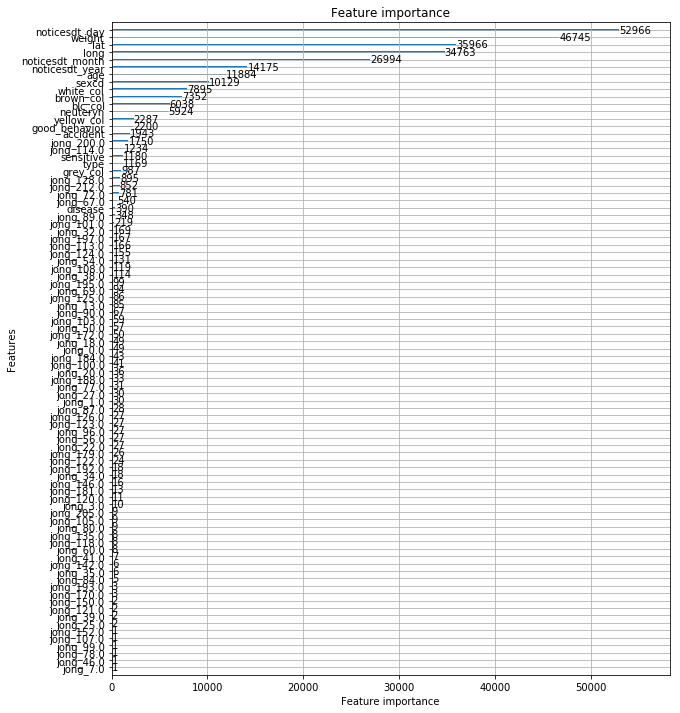

In [82]:
# 중요 피쳐 시각화 
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

## 8. 임곗값 선정 및 최종 점수 도출 

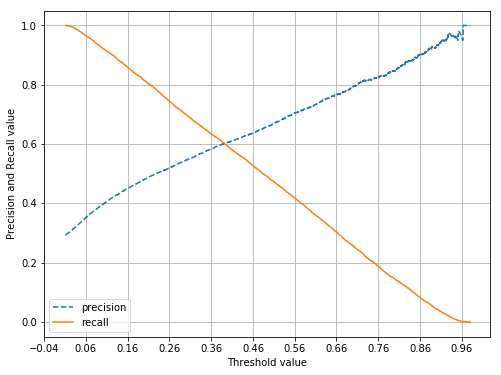

In [83]:
# f1 score 임곗값 조정 

def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold값 x축의 scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    #x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, pred_proba)

In [84]:
threshold = [0.2,0.29, 0.295, 0.3,0.31,0.35, 0.36, 0.37]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)



In [85]:
# threshold 조정 : 최종 점수 --> F1: 0.6133493131741495
get_eval_by_threshold(y_test, pred_proba.reshape(-1,1), threshold) #0.295

임곗값:  0.2
[[14598  8362]
 [ 1767  7744]]
정확도: 0.6880601151796988
F1: 0.6045985088027481
정밀도: 0.48081460325344594
재현률(민감도): 0.8142151193355063
ROC: 0.7250082565318646
임곗값:  0.29
[[17183  5777]
 [ 2749  6762]]
정확도: 0.7374272427704721
F1: 0.6133333333333333
정밀도: 0.5392774543424516
재현률(민감도): 0.7109662496057197
ROC: 0.7296773756739401
임곗값:  0.295
[[17303  5657]
 [ 2806  6705]]
정확도: 0.7393674355578824
F1: 0.6130846248799889
정밀도: 0.5423879631127649
재현률(민감도): 0.7049731889391231
ROC: 0.7292940857587601
임곗값:  0.3
[[17430  5530]
 [ 2858  6653]]
정확도: 0.741677188876228
F1: 0.6133493131741495
정밀도: 0.5460888122794058
재현률(민감도): 0.6995058353485438
ROC: 0.7293260884059792
임곗값:  0.31
[[17644  5316]
 [ 2965  6546]]
정확도: 0.7449724369437344
F1: 0.6125485425536892
정밀도: 0.5518462316641376
재현률(민감도): 0.6882557039217748
ROC: 0.7283613014382394
임곗값:  0.35
[[18479  4481]
 [ 3375  6136]]
정확도: 0.7580610390810262
F1: 0.6096979332273449
정밀도: 0.5779410379579919
재현률(민감도): 0.6451477236883608
ROC: 0.7249911092309401
임곗값: 